# **Titanic Competition: EDA & Feature Engineering & Modeling**

![](https://cdn.discordapp.com/attachments/1155170557013278860/1327747298616279141/masha_56797_an_art_of_the_titanic_ship._8ea3a1c3-7203-4f47-ae2d-9ab779f02837.png?ex=678cc248&is=678b70c8&hm=476bdb0962a8816ca33039b2aa775bd4a7fcd0687665fe8149c1e0be199d0407&)

# **Import Libraries**

In [2]:
# Import libraries
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
import missingno as msno  
import re

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.frame import H2OFrame

import missingno as msno # this helps to visualize the missing values


# Configuring Seaborn plot aesthetics
sns.set_theme(style='darkgrid', context='notebook')

import warnings # this helps to remove warnings that show up usually in red
warnings.filterwarnings("ignore")

# **Loan Datasets**

In [3]:
# Load datasets directly from Kaggle
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
# Combine the two dataset (this helps to make sure that they will stay consistent after implementing feature engineering)
# Add a column to indicate the dataset type
train["DatasetType"] = "train"
test["DatasetType"] = "test"

# Combine train and test
combined = pd.concat([train, test], axis=0).reset_index(drop=True)


# **Data Overview**

In [5]:
def data_overview(df, head_rows=5):
    """
    Provides a comprehensive overview of a DataFrame, including:
    - Shape of the DataFrame
    - First few rows (default 5)
    - Info (data types, non-null counts)
    - Basic descriptive statistics
    - Missing values (count and percentage)
    - Duplicate rows count
    - Number of unique values and the unique values for each column
    """
    print("======== DATA OVERVIEW ========")
    print(f"\n1. Shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns\n")

    print(f"2. First {head_rows} Rows:\n")
    display(df.head(head_rows))

    print("\n3. DataFrame Info:\n")
    print(df.info())

    print("\n4. Descriptive Statistics (Numerical Columns):\n")
    print(df.describe().transpose())

    print("\n5. Missing Values Count and Percentage:\n")
    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percentage (%)': missing_percentage
    })
    missing_data = missing_data[missing_data["Missing Count"] > 0].sort_values(by='Missing Percentage (%)', ascending=False)
    
    if not missing_data.empty:
        display(missing_data)
    else:
        print("No missing values")

    print("\n6. Duplicate Rows Count:\n")
    duplicate_count = df.duplicated().sum()
    print(f"{duplicate_count} duplicate rows found\n" if duplicate_count > 0 else "No duplicate rows found\n")

    print("\n7. Number of Unique Values per Column:\n")
    unique_counts = df.nunique()
    unique_values = {col: df[col].unique() for col in df.columns}
    for col in unique_counts.index:
        print(f"{col}: {unique_counts[col]} unique values")
        if unique_counts[col] <= 10:  # Print unique values only if there are <= 10 unique values for readability
            print(f"   Unique Values: {unique_values[col]}\n")
        else:
            print("   Too many unique values to display\n")

    print("===============================\n")

In [6]:
# check the basic information about this dataset
data_overview(combined)

======== DATA OVERVIEW ========

1. Shape of DataFrame: 1309 rows, 13 columns

2. First 5 Rows:



PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked DatasetType  
0      0         A/5 21171   7.2500   NaN        S       train  
1      0          PC 17599  71.2833   C85        C       train  
2      0  STON/O2. 3101282   7.9250   NaN        S       train  
3      0            113803  53.1000  C123        S       train  
4      0            373450   8.0500   NaN        S       train


3. DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  DatasetType  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB
None

4. Descriptive Statistics (Numerical Columns):

              count        mean         std   min       25%       50%  \
PassengerId  1309.0  655.000000  378.020061  1.00  

Missing Count  Missing Percentage (%)
Cabin              1014               77.463713
Survived            418               31.932773
Age                 263               20.091673
Embarked              2                0.152788
Fare                  1                0.076394


6. Duplicate Rows Count:

No duplicate rows found


7. Number of Unique Values per Column:

PassengerId: 1309 unique values
   Too many unique values to display

Survived: 2 unique values
   Unique Values: [ 0.  1. nan]

Pclass: 3 unique values
   Unique Values: [3 1 2]

Name: 1307 unique values
   Too many unique values to display

Sex: 2 unique values
   Unique Values: ['male' 'female']

Age: 98 unique values
   Too many unique values to display

SibSp: 7 unique values
   Unique Values: [1 0 3 4 2 5 8]

Parch: 8 unique values
   Unique Values: [0 1 2 5 3 4 6 9]

Ticket: 929 unique values
   Too many unique values to display

Fare: 281 unique values
   Too many unique values to display

Cabin: 186 unique values
   Too many unique values to display

Embarked: 3 unique values
   Unique Values: ['S' 'C' 'Q' nan]

DatasetType: 2 unique values
   Unique Values: ['train' 'test']




In [7]:
# Converting data types
combined['Survived'] = combined['Survived'].astype('category')
combined['Pclass'] = combined['Pclass'].astype('category')
combined['Sex'] = combined['Sex'].astype('category')
combined['Cabin'] = combined['Cabin'].astype('category')
combined['Embarked'] = combined['Embarked'].astype('category')
combined['Name'] = combined['Name'].astype('category')
combined['Ticket'] = combined['Ticket'].astype('category')
combined['DatasetType'] = combined['DatasetType'].astype('category')
combined['PassengerId'] = combined['PassengerId'].astype('category')

In [8]:
# Check after changes
data_overview(combined)

======== DATA OVERVIEW ========

1. Shape of DataFrame: 1309 rows, 13 columns

2. First 5 Rows:



PassengerId Survived Pclass  \
0           1      0.0      3   
1           2      1.0      1   
2           3      1.0      3   
3           4      1.0      1   
4           5      0.0      3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked DatasetType  
0      0         A/5 21171   7.2500   NaN        S       train  
1      0          PC 17599  71.2833   C85        C       train  
2      0  STON/O2. 3101282   7.9250   NaN        S       train  
3      0            113803  53.1000  C123        S       train  
4      0            373450   8.0500   NaN        S       train


3. DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   category
 1   Survived     891 non-null    category
 2   Pclass       1309 non-null   category
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   int64   
 7   Parch        1309 non-null   int64   
 8   Ticket       1309 non-null   category
 9   Fare         1308 non-null   float64 
 10  Cabin        295 non-null    category
 11  Embarked     1307 non-null   category
 12  DatasetType  1309 non-null   category
dtypes: category(9), float64(2), int64(2)
memory usage: 188.4 KB
None

4. Descriptive Statistics (Numerical Columns):

        count       mean        std   min      25%      50%     75%       max
Age    1046.0  29.881138  14.4

Missing Count  Missing Percentage (%)
Cabin              1014               77.463713
Survived            418               31.932773
Age                 263               20.091673
Embarked              2                0.152788
Fare                  1                0.076394


6. Duplicate Rows Count:

No duplicate rows found


7. Number of Unique Values per Column:

PassengerId: 1309 unique values
   Too many unique values to display

Survived: 2 unique values
   Unique Values: [0.0, 1.0, NaN]
Categories (2, float64): [0.0, 1.0]

Pclass: 3 unique values
   Unique Values: [3, 1, 2]
Categories (3, int64): [1, 2, 3]

Name: 1307 unique values
   Too many unique values to display

Sex: 2 unique values
   Unique Values: ['male', 'female']
Categories (2, object): ['female', 'male']

Age: 98 unique values
   Too many unique values to display

SibSp: 7 unique values
   Unique Values: [1 0 3 4 2 5 8]

Parch: 8 unique values
   Unique Values: [0 1 2 5 3 4 6 9]

Ticket: 929 unique values
   Too many unique values to display

Fare: 281 unique values
   Too many unique values to display

Cabin: 186 unique values
   Too many unique values to display

Embarked: 3 unique values
   Unique Values: ['S', 'C', 'Q', NaN]
Categories (3, object): ['C', 'Q', 'S']

DatasetType: 2 u

# **Feature Engineering**

## 1 Create a feature of the Title

In [9]:
# Function to extract title from the Name
def extract_title(Name):
    title_search = re.search(r',\s*([^\.]*)\.', Name)
    if title_search:
        return title_search.group(1).strip()
    return ""

# Function to extract family name from the Name
def extract_family_name(Name):
    family_name = Name.split(",")[0].strip()
    return family_name

# Create new columns for Title and Family Name
combined["Title"] = combined["Name"].apply(extract_title).astype('category')
combined["FamilyName"] = combined["Name"].apply(extract_family_name).astype('category')

# check the new columns
print(combined["Title"].unique())
print(combined["FamilyName"].unique())

['Mr', 'Mrs', 'Miss', 'Master', 'Don', ..., 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']
Length: 18
Categories (18, object): ['Capt', 'Col', 'Don', 'Dona', ..., 'Ms', 'Rev', 'Sir', 'the Countess']
['Braund', 'Cumings', 'Heikkinen', 'Futrelle', 'Allen', ..., 'Naughton', 'Henriksson', 'Spector', 'Oliva y Ocana', 'Saether']
Length: 875
Categories (875, object): ['Abbing', 'Abbott', 'Abelseth', 'Abelson', ..., 'de Pelsmaeker', 'del Carlo', 'van Billiard', 'van Melkebeke']


## 2 Grouping Title into broader categories

In [10]:
# Grouping titles into broader categories
def encode_title(title):
    if title in ['Mr', 'Mrs', 'Miss', 'Master']:
        return title  # Keep common titles as they are
    elif title in ['Mlle', 'Ms']:  # Alternative spellings for Miss
        return 'Miss'
    elif title in ['Mme']:  # Alternative spelling for Mrs
        return 'Mrs'
    elif title in ['Dr', 'Major', 'Col', 'Capt', 'Rev']:
        return 'Officer'  # Group into an 'Officer' category
    elif title in ['Don', 'Sir', 'the Countess', 'Lady', 'Jonkheer']:
        return 'Noble'  # Group into a 'Noble' category
    else:
        return 'Other'  # Catch-all for any unusual titles

# Apply title encoding
combined["TitleEncoded"] = combined["Title"].apply(encode_title).astype('category')

# Check the new column
combined["TitleEncoded"].unique()

['Mr', 'Mrs', 'Miss', 'Master', 'Noble', 'Officer', 'Other']
Categories (7, object): ['Master', 'Miss', 'Mr', 'Mrs', 'Noble', 'Officer', 'Other']

## 3 Create a feature of Family Size

In [11]:
# Create a "FamilySize" feature by summing SibSp (siblings/spouses) and Parch (parents/children) plus 1 (the individual themselves)
combined["FamilySize"] = combined["SibSp"] + combined["Parch"] + 1

# Create a "FamilyGroup" feature based on FamilySize
def categorize_family_size(size):
    if size == 1:
        return "Solo"  # No family members on board
    elif size <= 4:
        return "Small"  # Small family (1-3 additional members)
    else:
        return "Large"  # Large family (4+ additional members)

combined["FamilyGroup"] = combined["FamilySize"].apply(categorize_family_size).astype('category')

# Check the new column
combined["FamilyGroup"].unique()

['Small', 'Solo', 'Large']
Categories (3, object): ['Large', 'Small', 'Solo']

## 4 Create a feature of a numerica Family Size

In [12]:
# Create a numeric family size category based on the actual number of family members
def numeric_family_size_category(size):
    if size == 1:
        return 0  # Solo travelers (no family)
    elif size <= 4:
        return 1  # Small family
    else:
        return 2  # Large family

# Create a new column for numeric family size category
combined["NumericFamilySize"] = combined["FamilySize"].apply(numeric_family_size_category).astype('int')

# Check the new column
combined["NumericFamilySize"].unique()

array([1, 0, 2])

## 5 Create a feature of the economic status of a passenger

In [13]:
# Function to categorize passenger as "Wealthy", "Middle", "Low", or "Employee"
combined["TicketPrefix"] = combined["Ticket"].apply(lambda x: x.split(" ")[0] if not x.isdigit() else "None")

def classify_status(row):
    if row["Fare"] == 0 or row["TicketPrefix"] in ["LINE", "W.E.P.", "A/5", "A/4"]:
        return "Employee"  # Likely crew members or service roles
    elif row["Pclass"] == 1 and row["Fare"] > 100:
        return "Wealthy"  # High-paying first-class passengers
    elif row["Pclass"] == 2 or (row["Pclass"] == 1 and row["Fare"] <= 100):
        return "Middle"  # Middle-class or modest first-class passengers
    else:
        return "Low"  # Third-class passengers or immigrants

# Apply the classification function to create a new column
combined["PassengerStatus"] = combined.apply(classify_status, axis=1).astype('category')

# Check the new column
combined["PassengerStatus"].unique()


['Employee', 'Middle', 'Low', 'Wealthy']
Categories (4, object): ['Employee', 'Low', 'Middle', 'Wealthy']

## 6 Create a feature of the social status of a passenger

In [14]:
# Function to further classify passenger status
def detailed_classify_status(row):
    ticket_prefix = row["TicketPrefix"]
    fare = row["Fare"]
    pclass = row["Pclass"]

    # Check for specific immigrant patterns (common third-class ticket prefixes and low fares)
    if ticket_prefix in ["STON/O", "A/5", "A/4", "SOTON/O.Q.", "SOTON/OQ", "SC/AH", "C.A./SOTON", "A.5."] or fare < 10:
        return "Migrant"  # Likely immigrants or low-income passengers

    # Identify service crew members based on specific ticket patterns or zero fares
    if fare == 0 or ticket_prefix in ["LINE", "W.E.P.", "SW/PP", "S.C./A.4.", "P/PP"]:
        return "Crew"  # Crew members with assigned tickets

    # High-paying first-class with luxury tickets
    if pclass == 1 and fare > 100:
        return "Wealthy Passenger"

    # Second-class or modest-paying first-class passengers
    if pclass == 2 or (pclass == 1 and fare <= 100):
        return "Middle-Class Passenger"

    # Default to low-class passengers if none of the above match
    return "Low-Class Passenger"

# Apply the detailed classification function
combined["DetailedPassengerStatus"] = combined.apply(detailed_classify_status, axis=1).astype('category')

# Check the new column
combined["DetailedPassengerStatus"].unique()


['Migrant', 'Middle-Class Passenger', 'Low-Class Passenger', 'Wealthy Passenger', 'Crew']
Categories (5, object): ['Crew', 'Low-Class Passenger', 'Middle-Class Passenger', 'Migrant', 'Wealthy Passenger']

## 7 Create a feautre of the Group size

In [15]:
# GroupSize: Number of passengers sharing the same ticket
combined["GroupSize"] = combined.groupby("Ticket")["Ticket"].transform("count").astype('int')

# Check the new column
combined["GroupSize"].unique()

array([ 1,  2,  5,  3,  7,  6,  4,  8, 11])

## 8 Create a feature of the age group

In [16]:
# Age Binning: Categorize age into groups
def categorize_age(age):
    if pd.isna(age):
        return "Unknown"
    elif age <= 12:
        return "Child"
    elif age <= 19:
        return "Teen"
    elif age <= 59:
        return "Adult"
    else:
        return "Senior"

combined["AgeGroup"] = combined["Age"].apply(categorize_age).astype('category')

# Check the new column
combined["AgeGroup"].unique()

['Adult', 'Unknown', 'Child', 'Teen', 'Senior']
Categories (5, object): ['Adult', 'Child', 'Senior', 'Teen', 'Unknown']

## 9 Extract Deck from Cabin

In [17]:
# Ensure "Unknown" is added to the categories of the 'Cabin' column
if combined["Cabin"].dtype.name == "category":
    combined["Cabin"] = combined["Cabin"].cat.add_categories(["Unknown"])
    
# Deck Extraction: Extract the first letter of the cabin (or "Unknown" if missing)
combined["Deck"] = combined["Cabin"].fillna("Unknown").apply(lambda x: x[0]).astype('category')

# Check the new column
combined["Deck"].unique()

['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']
Categories (9, object): ['A', 'B', 'C', 'D', ..., 'F', 'G', 'T', 'U']

## 10 Create a feature is alone traveler

In [18]:
# IsAlone: Boolean feature indicating whether the passenger is traveling alone
combined["IsAlone"] = combined["FamilySize"].apply(lambda x: 1 if x == 1 else 0).astype('category')

# Check the new column
combined["IsAlone"].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [19]:
# FarePerPerson: Calculate fare per person
combined["FarePerPerson"] = combined["Fare"] / combined["GroupSize"]

# Check the new column
combined["FarePerPerson"].mean()

14.757627255351684

In [20]:
# Name Length: Calculate the length of the passenger's name
combined["NameLength"] = combined["Name"].apply(len).astype('int')

# Check the new column
combined["NameLength"].unique()

array([23, 51, 22, 44, 24, 16, 30, 49, 35, 31, 27, 36, 32, 20, 28, 55, 21,
       29, 57, 19, 46, 34, 56, 40, 17, 25, 45, 26, 50, 13, 15, 33, 18, 52,
       47, 38, 37, 41, 14, 42, 39, 82, 48, 54, 43, 67, 65, 53, 61, 12, 59,
       62, 58, 63])

In [21]:
# Port of Embarkation Encoding: Encoding the port of embarkation
port_mapping = {"C": "Cherbourg", "S": "Southampton", "Q": "Queenstown"}
combined["EmbarkedCategory"] = combined["Embarked"].map(port_mapping).astype('category')

# Check the new column
combined["EmbarkedCategory"].unique()

['Southampton', 'Cherbourg', 'Queenstown', NaN]
Categories (3, object): ['Cherbourg', 'Queenstown', 'Southampton']

In [22]:
# Interaction Terms: Create combined features
combined["Pclass_Fare"] = combined["Pclass"].astype(float) * combined["Fare"].astype(float)
combined["Title_AgeGroup"] = combined["TitleEncoded"].astype(str) + "_" + combined["AgeGroup"].astype(str)
combined['Title_AgeGroup'] = combined['Title_AgeGroup'].astype('category')

# Check the new columns
print(combined["Title_AgeGroup"].unique())
print(combined["Pclass_Fare"].head())

['Mr_Adult', 'Mrs_Adult', 'Miss_Adult', 'Mr_Unknown', 'Master_Child', ..., 'Officer_Senior', 'Mr_Child', 'Officer_Unknown', 'Master_Teen', 'Other_Adult']
Length: 22
Categories (22, object): ['Master_Child', 'Master_Teen', 'Master_Unknown', 'Miss_Adult', ..., 'Officer_Adult', 'Officer_Senior', 'Officer_Unknown', 'Other_Adult']
0    21.7500
1    71.2833
2    23.7750
3    53.1000
4    24.1500
Name: Pclass_Fare, dtype: float64


# **Feature Engineering**

In [23]:
combined.isnull().sum()

PassengerId                   0
Survived                    418
Pclass                        0
Name                          0
Sex                           0
Age                         263
SibSp                         0
Parch                         0
Ticket                        0
Fare                          1
Cabin                      1014
Embarked                      2
DatasetType                   0
Title                         0
FamilyName                    0
TitleEncoded                  0
FamilySize                    0
FamilyGroup                   0
NumericFamilySize             0
TicketPrefix                  0
PassengerStatus               0
DetailedPassengerStatus       0
GroupSize                     0
AgeGroup                      0
Deck                          0
IsAlone                       0
FarePerPerson                 1
NameLength                    0
EmbarkedCategory              2
Pclass_Fare                   1
Title_AgeGroup                0
dtype: i

## 1 Impute the Pclass_fare with the median grouped by Pclass, Embarked, Title

In [24]:
# Check the row with missing Pclass_Fare
combined[combined["Pclass_Fare"].isna()]

# Group by relevant features and compute the median Pclass_Fare
median_pclass_fare = combined.groupby(["Pclass", "Embarked", "Title"])["Pclass_Fare"].median()

# Impute the missing value
combined["Pclass_Fare"] = combined.apply(
    lambda row: median_pclass_fare.loc[row["Pclass"], row["Embarked"], row["Title"]]
    if pd.isna(row["Pclass_Fare"]) else row["Pclass_Fare"],
    axis=1
)

## 2 Predict the Age using the following: Pclass, TitleEncoded, and Family Size

In [25]:
# Encode categorical features to numerical values
label_encoder = LabelEncoder()
combined["TitleEncoded"] = label_encoder.fit_transform(combined["TitleEncoded"])
combined["AgeGroupEncoded"] = label_encoder.fit_transform(combined["AgeGroup"].astype(str))  

# Features for predicting Age
age_features = combined[['Pclass', 'TitleEncoded', 'FamilySize']]

# Remove rows with missing values in features
age_features = age_features[combined["Age"].notna()]
age_target = combined["Age"].dropna()

# Train the regression model
age_model = LinearRegression()
age_model.fit(age_features, age_target)

# Predict missing ages
combined.loc[combined["Age"].isna(), "Age"] = age_model.predict(combined[['Pclass', 'TitleEncoded', 'FamilySize']][combined["Age"].isna()])

## 3 Impute the missing values in Cabin with unknown

In [28]:
# Ensure all missing Cabin values are explicitly set to "Unknown"
combined["Cabin"] = combined["Cabin"].fillna("Unknown")

# Extract the deck from the first character of the Cabin value
combined["Deck"] = combined["Cabin"].apply(lambda x: x[0] if x != "Unknown" else "U")

# Check the unique Deck values
print(combined["Deck"].unique())

['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


## 4 Impute Embarked with the mode, of Pclass and Fare

In [29]:
#Embark
mode_embarked = combined.groupby(["Pclass", "Fare"])["Embarked"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else "S")
combined["Embarked"] = combined.apply(lambda row: mode_embarked.loc[row["Pclass"], row["Fare"]] if pd.isna(row["Embarked"]) else row["Embarked"], axis=1)

## 5 Impute the Fare with median by Pcalss and Embarked

In [30]:
#Fare
fare_median = combined.groupby(["Pclass", "Embarked"])["Fare"].median()
combined["Fare"] = combined.apply(lambda row: fare_median.loc[row["Pclass"], row["Embarked"]] if pd.isna(row["Fare"]) else row["Fare"], axis=1)

## 6 Recalculate the two features we created, fare per person and embarkedcategory

In [31]:
# FarePerPerson: Calculate fare per person
combined["FarePerPerson"] = combined["Fare"] / combined["GroupSize"]

# Port of Embarkation Encoding: Encoding the port of embarkation
port_mapping = {"C": "Cherbourg", "S": "Southampton", "Q": "Queenstown"}
combined["EmbarkedCategory"] = combined["Embarked"].map(port_mapping)

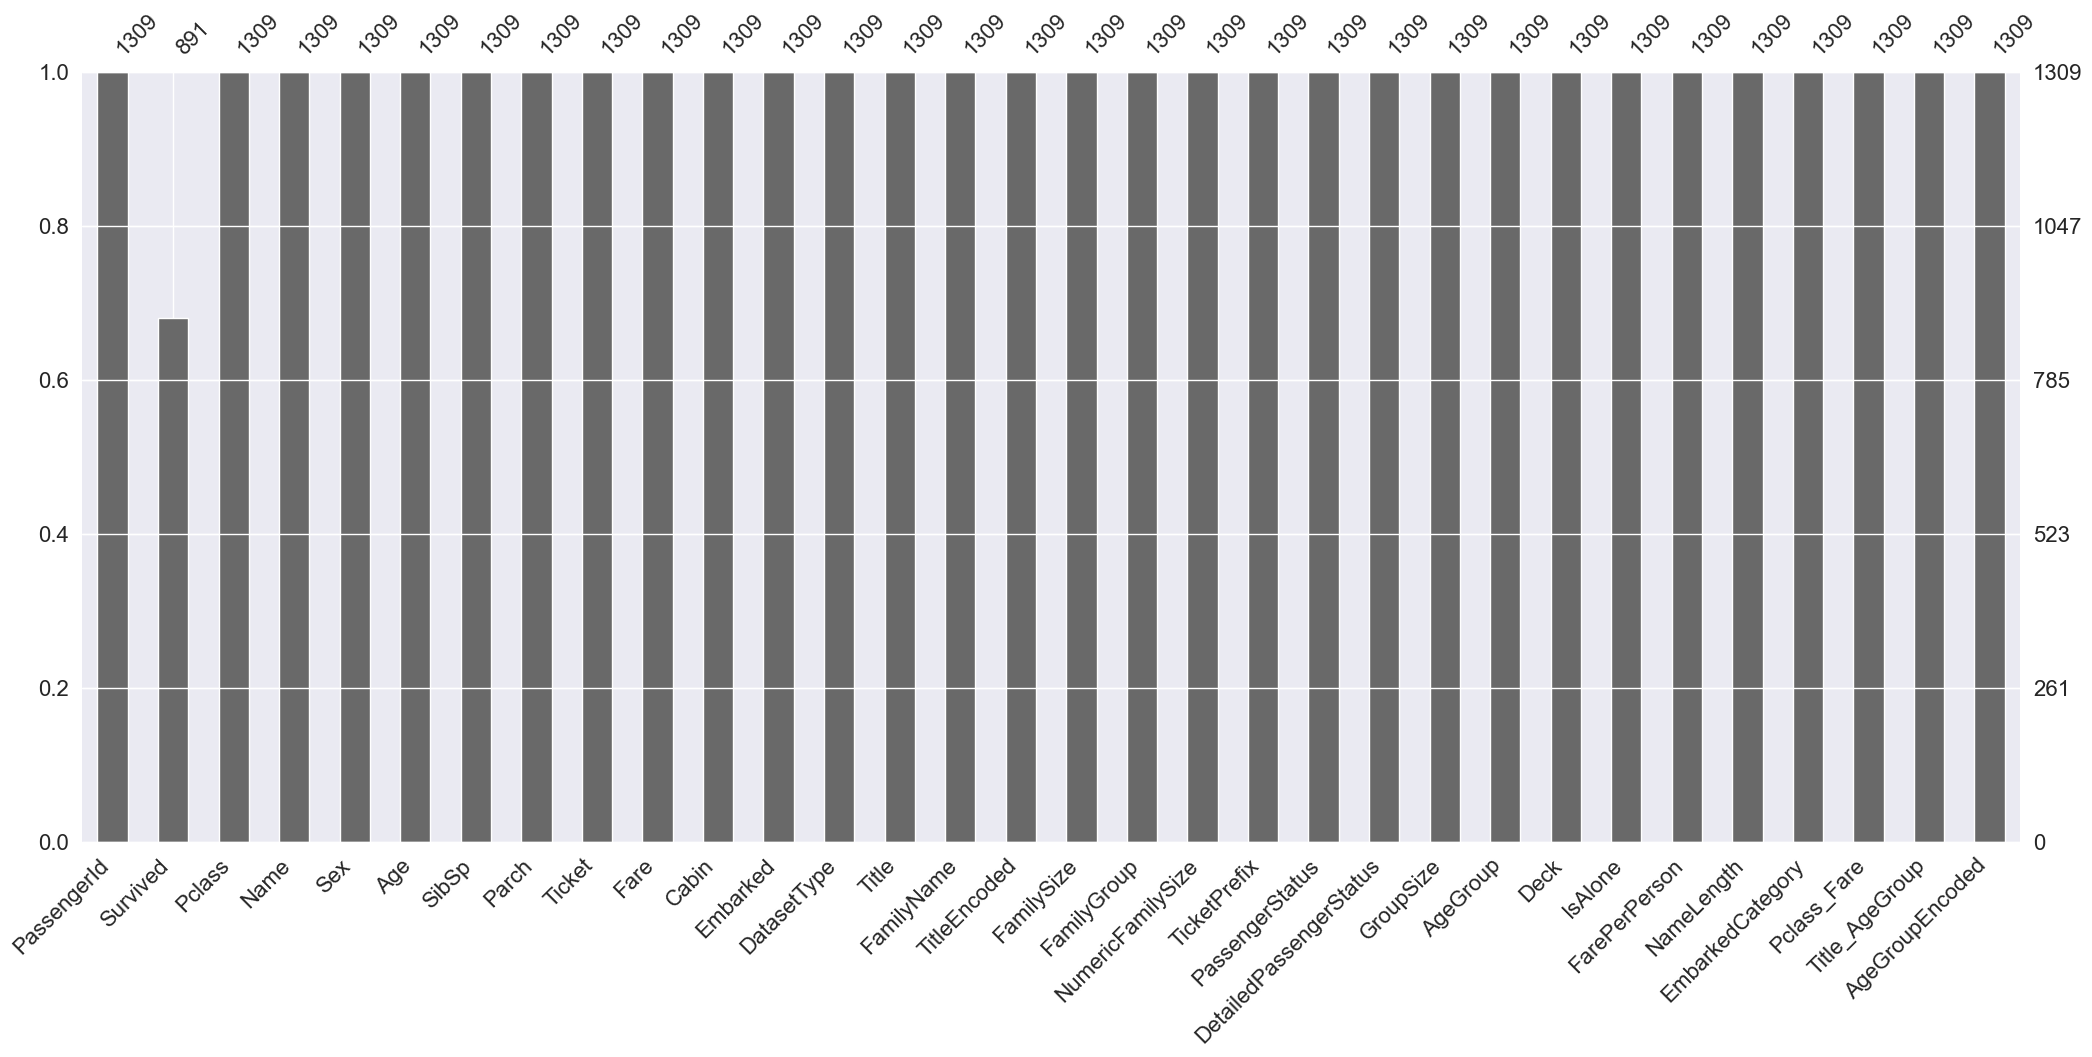

In [32]:
plt.figure(figsize=(10, 6))
msno.bar(combined)
plt.show()

# **Exploratory Data Analysis EDA**

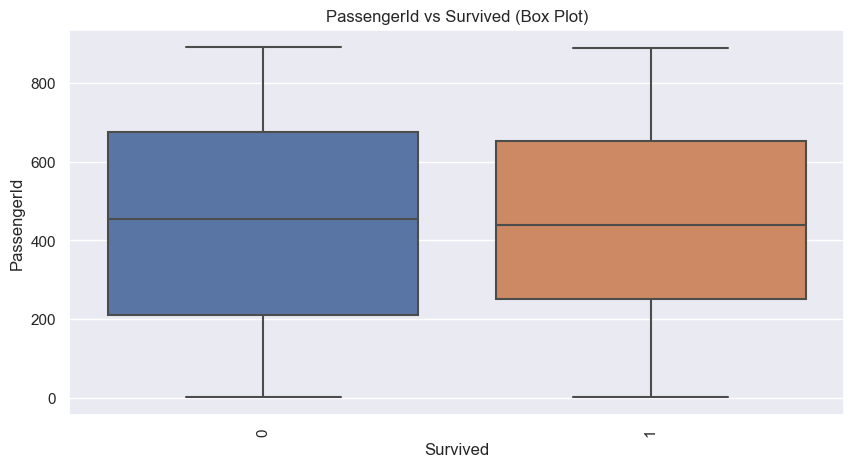

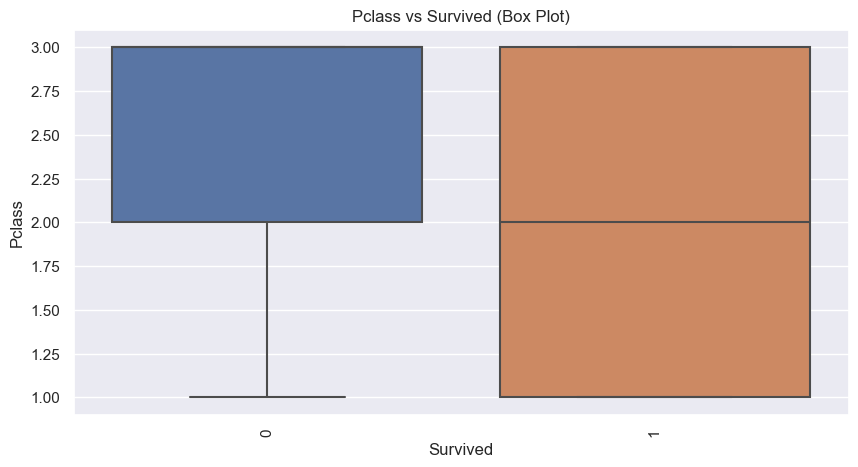

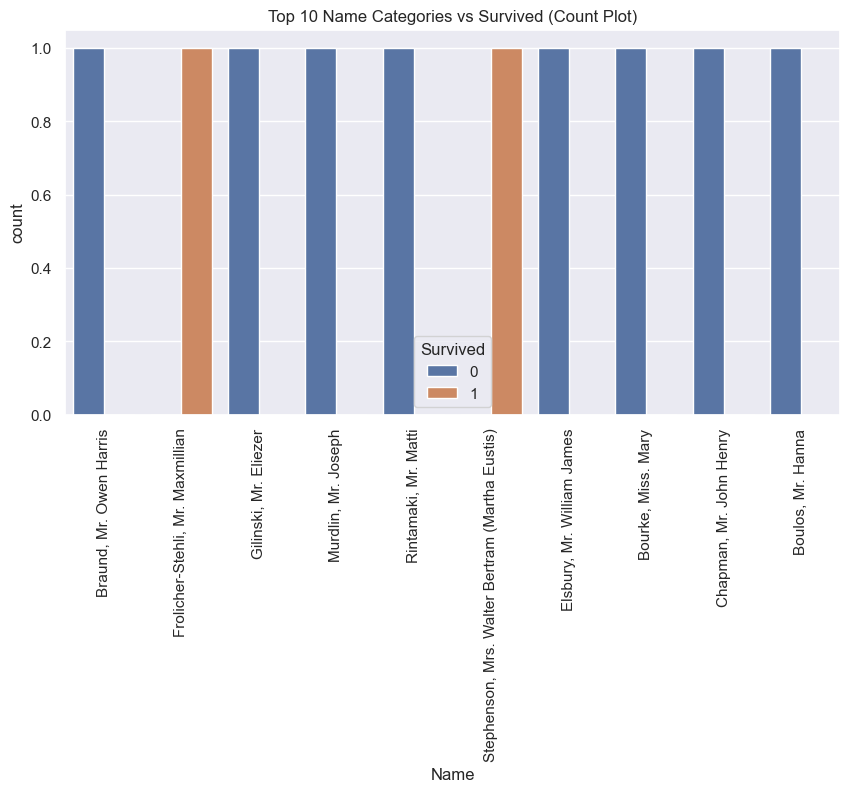

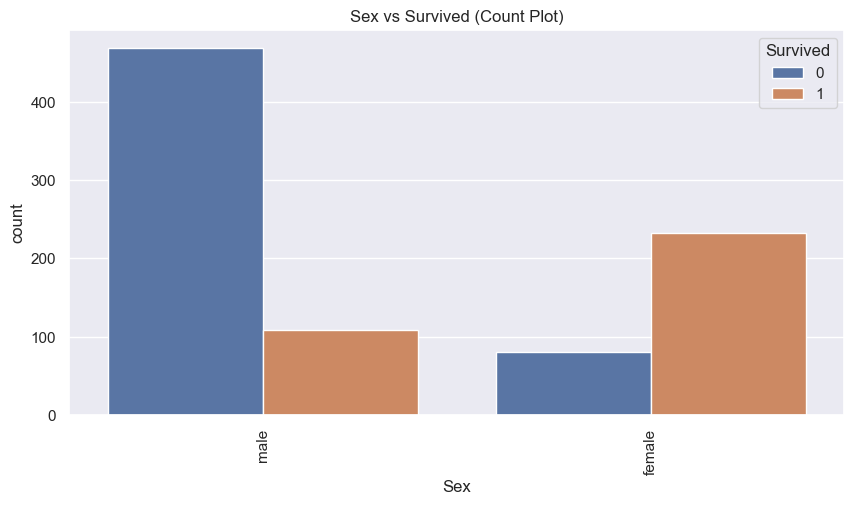

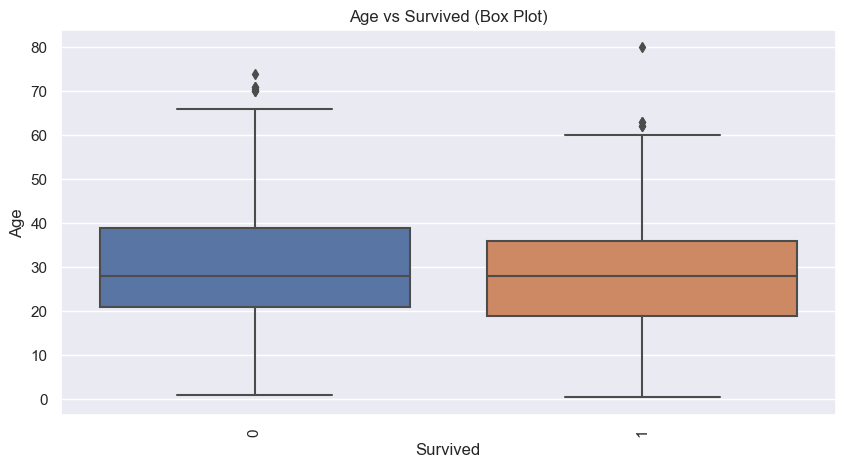

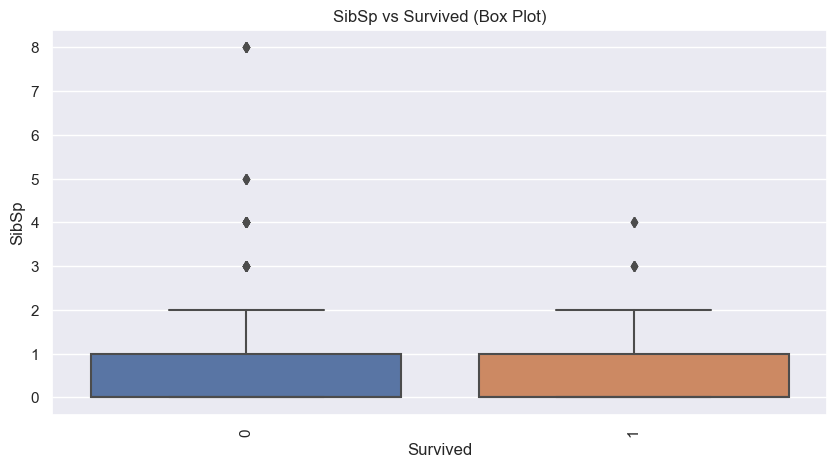

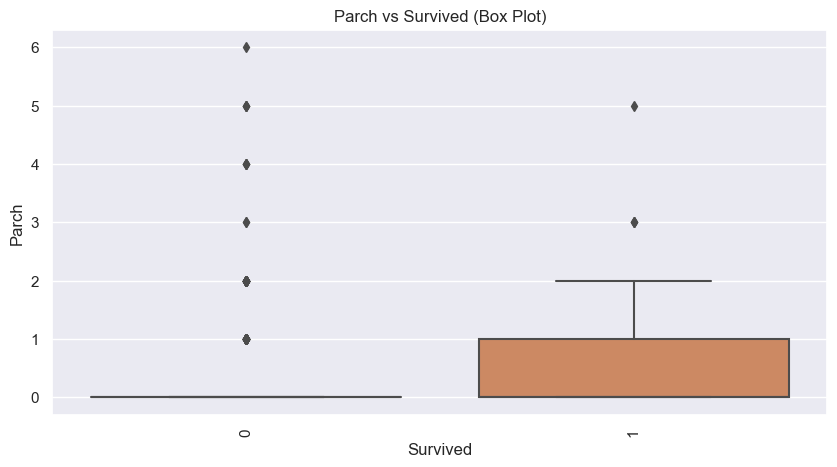

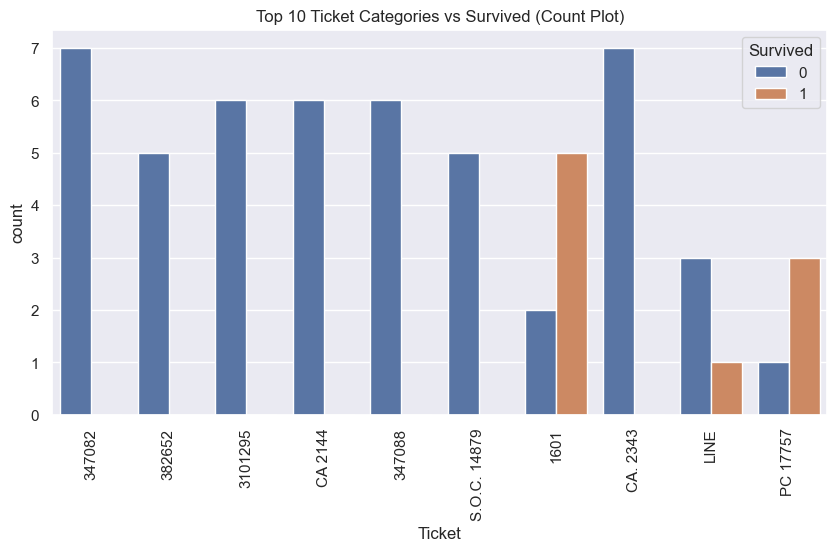

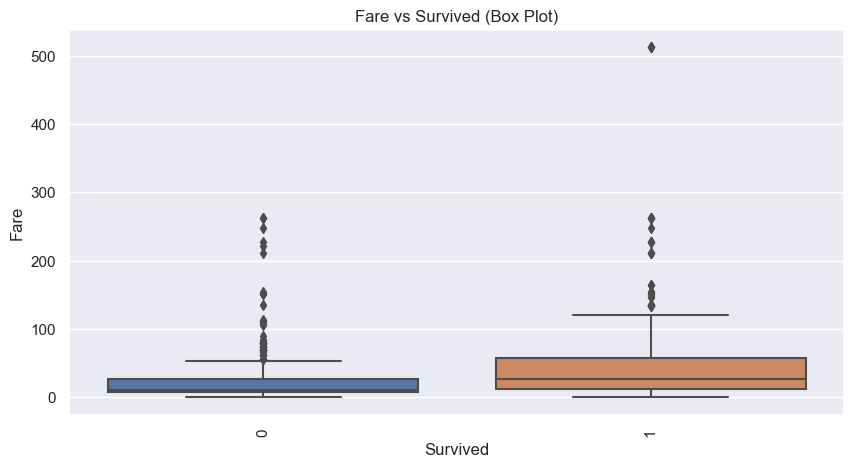

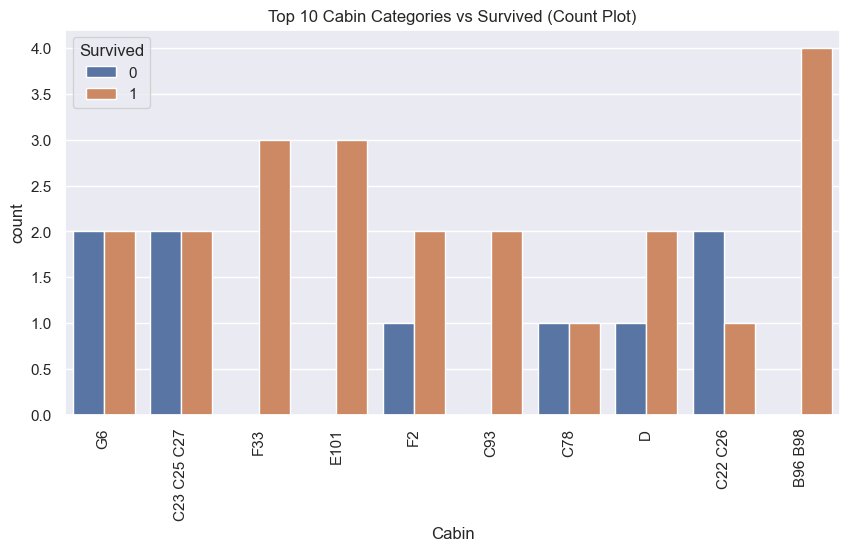

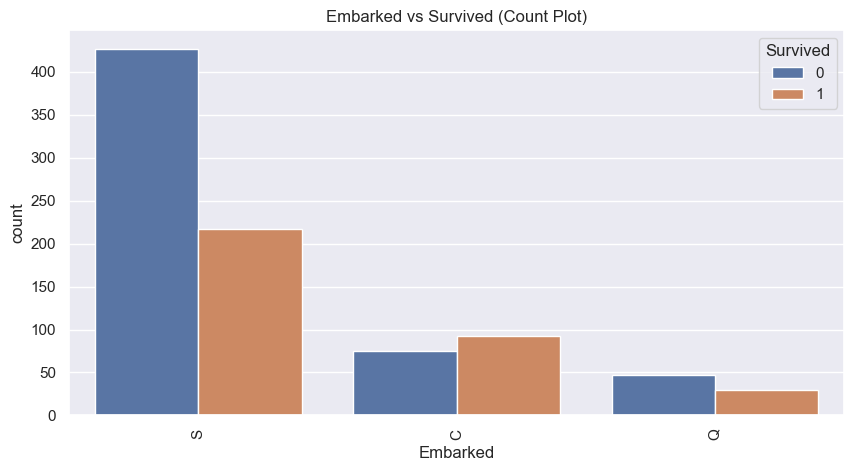

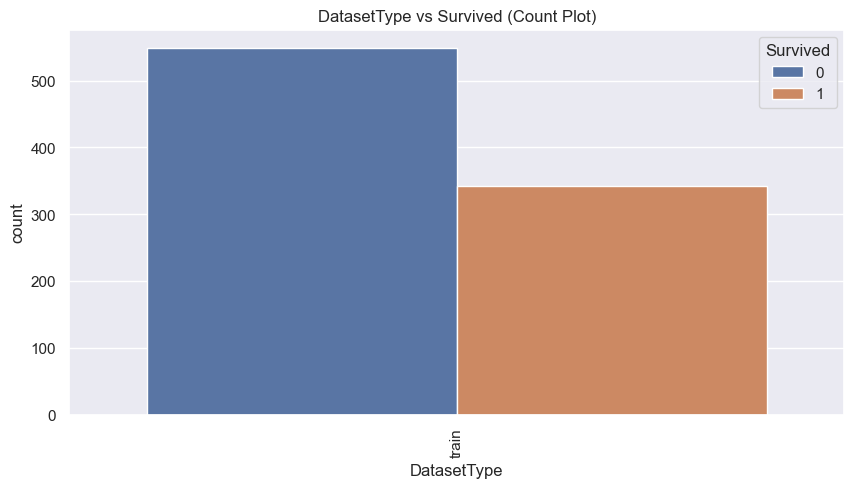

In [33]:
def univariate_analysis(df, target):
    # Separate numerical and categorical features
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in df.columns:
        if col == target:
            continue

        plt.figure(figsize=(10, 5))
        if col in num_cols:
            # Numerical feature
            sns.boxplot(x=target, y=col, data=df)
            plt.title(f'{col} vs {target} (Box Plot)')
        elif col in cat_cols:
            # Categorical feature
            if df[col].nunique() > 10:
                # Show only top 10 categories by frequency
                top_10_categories = df[col].value_counts().head(10).index
                temp_df = df[df[col].isin(top_10_categories)]
                sns.countplot(x=col, hue=target, data=temp_df)
                plt.title(f'Top 10 {col} Categories vs {target} (Count Plot)')
            else:
                sns.countplot(x=col, hue=target, data=df)
                plt.title(f'{col} vs {target} (Count Plot)')
        plt.xticks(rotation=90)
        plt.show()


univariate_analysis(train, "Survived")

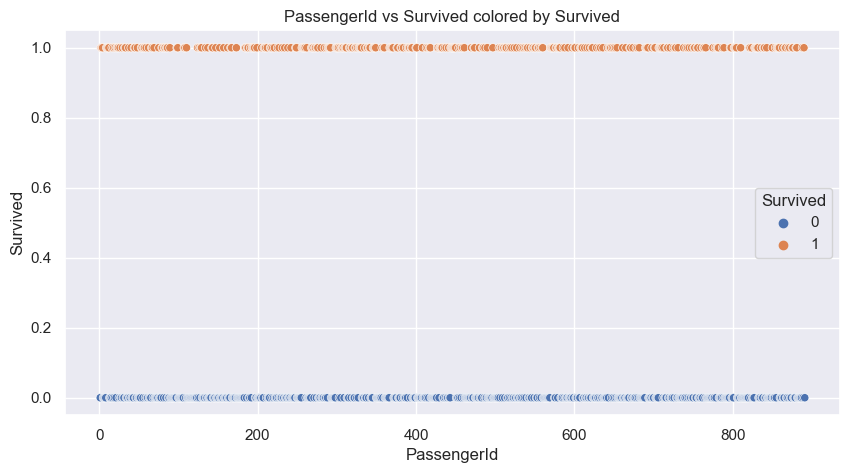

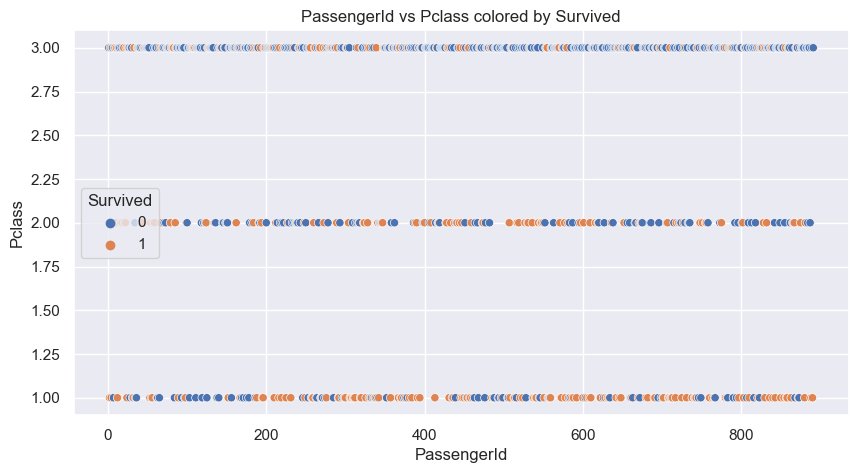

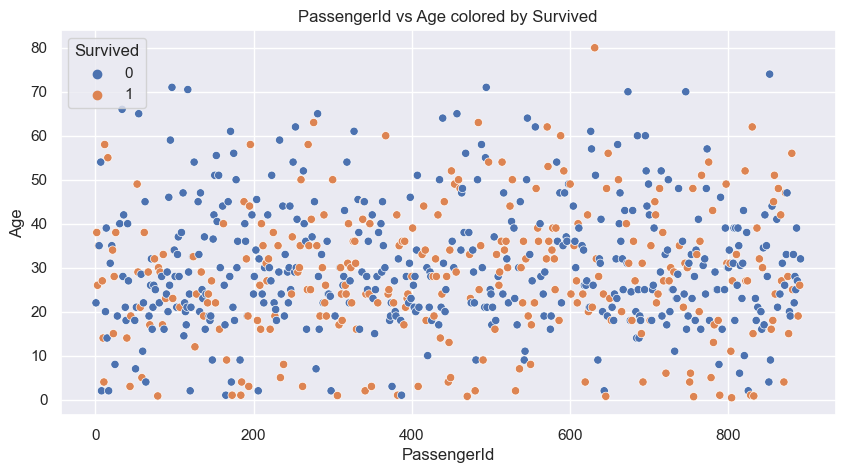

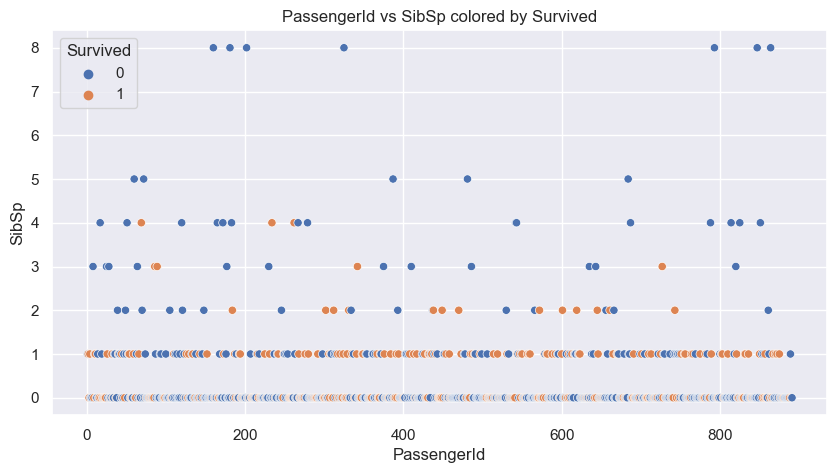

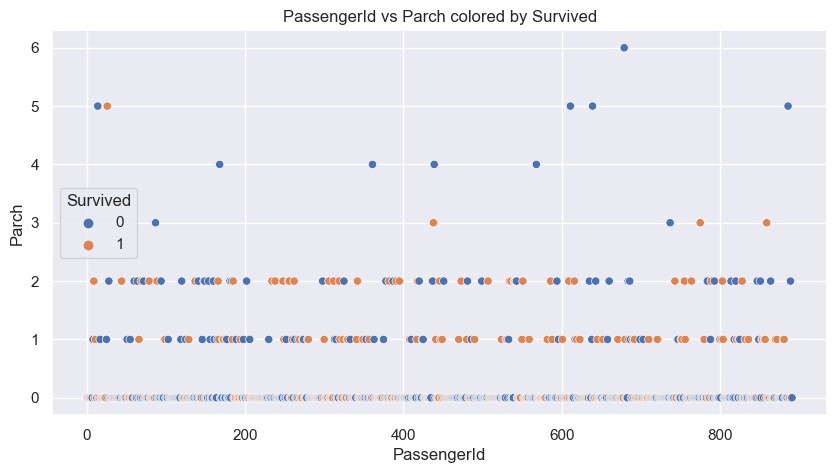

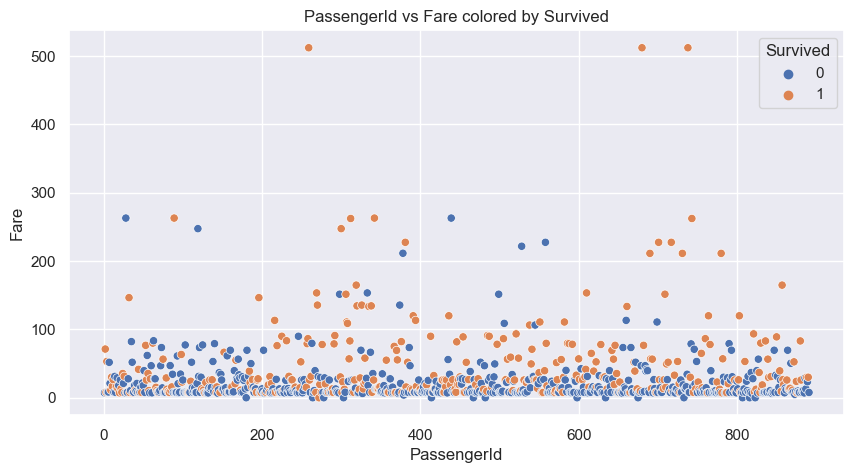

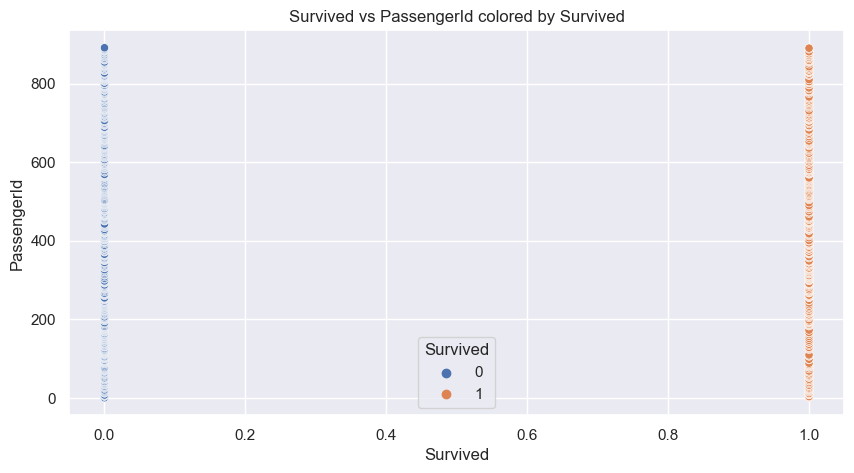

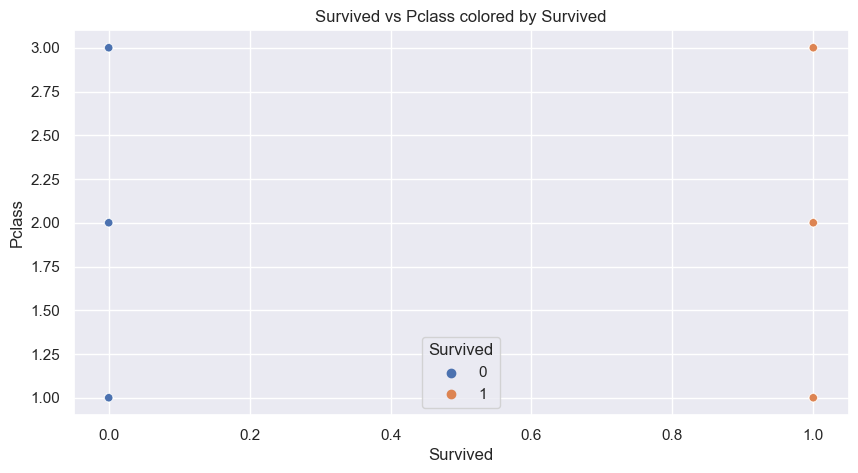

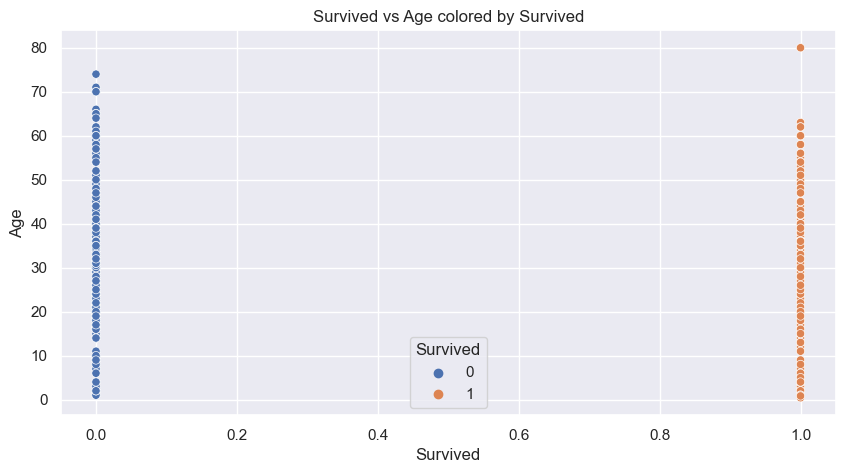

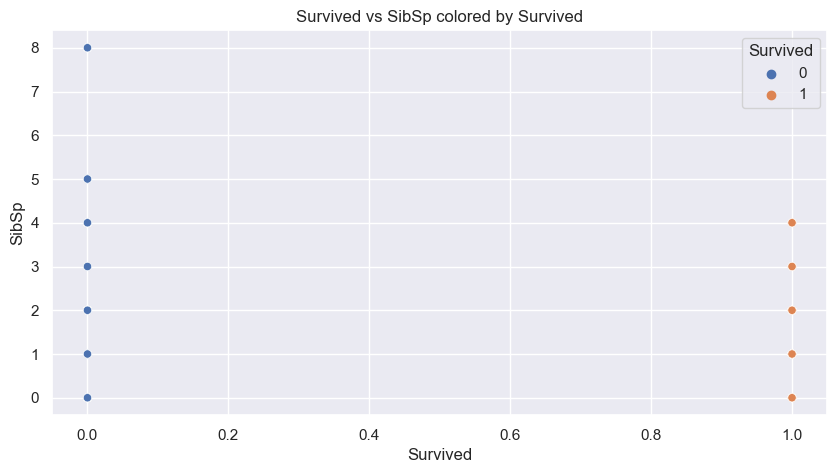

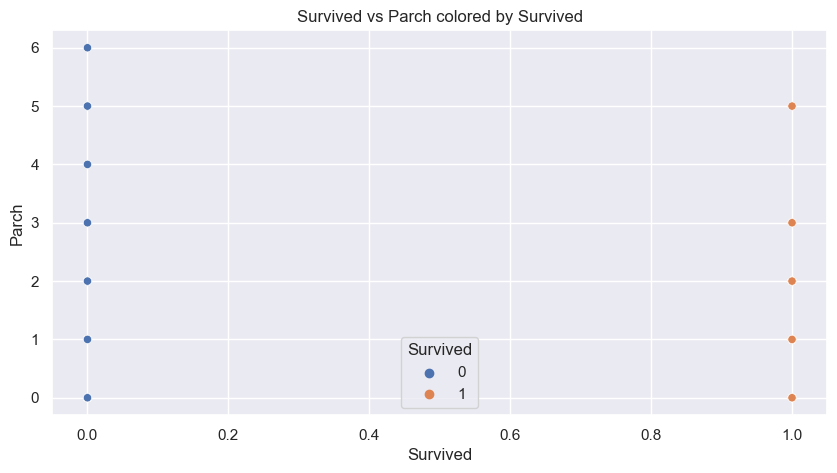

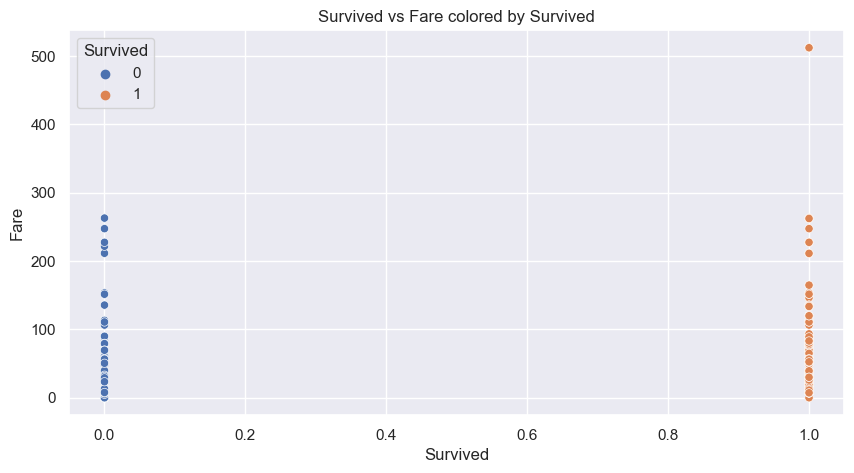

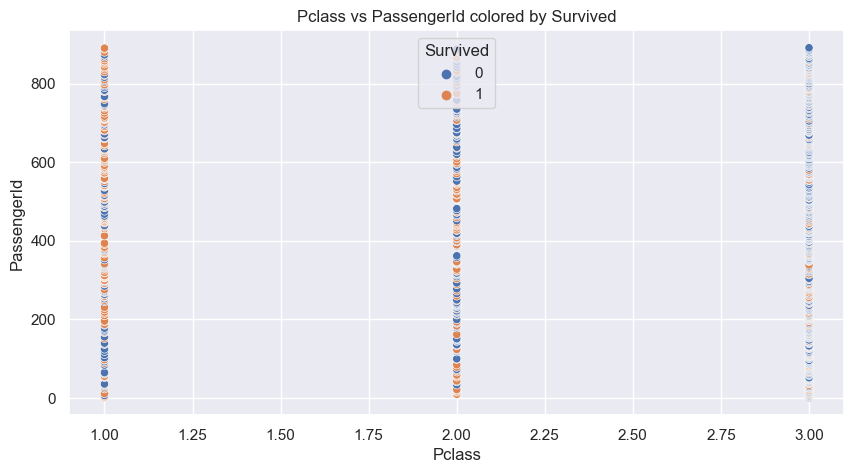

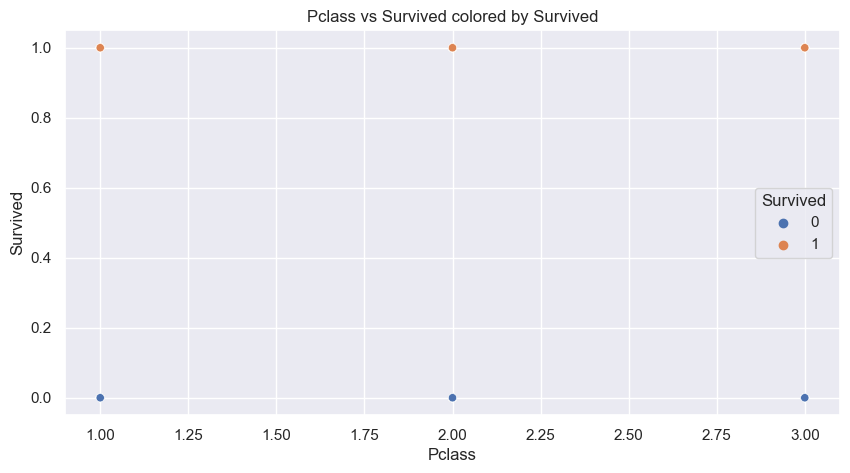

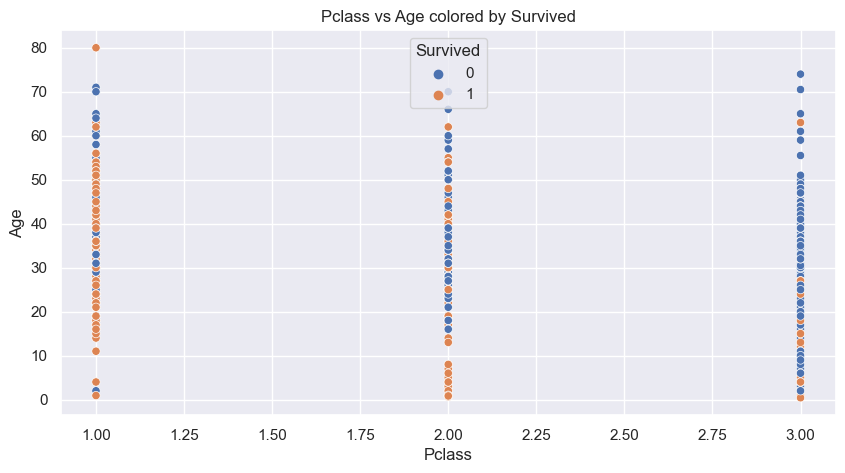

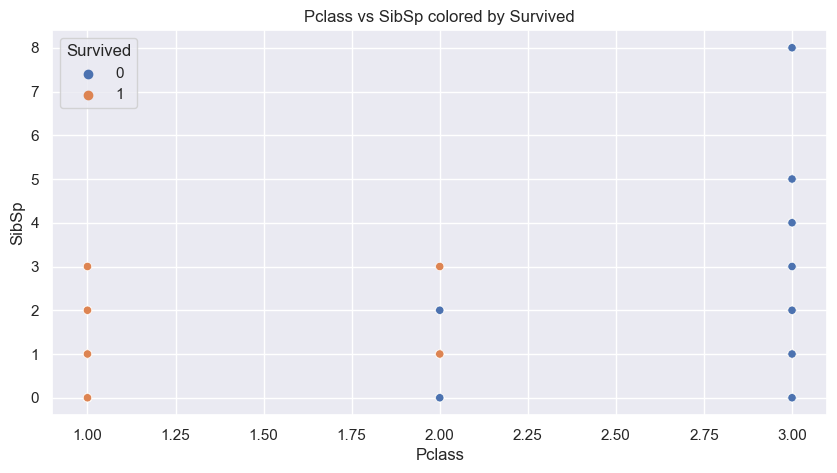

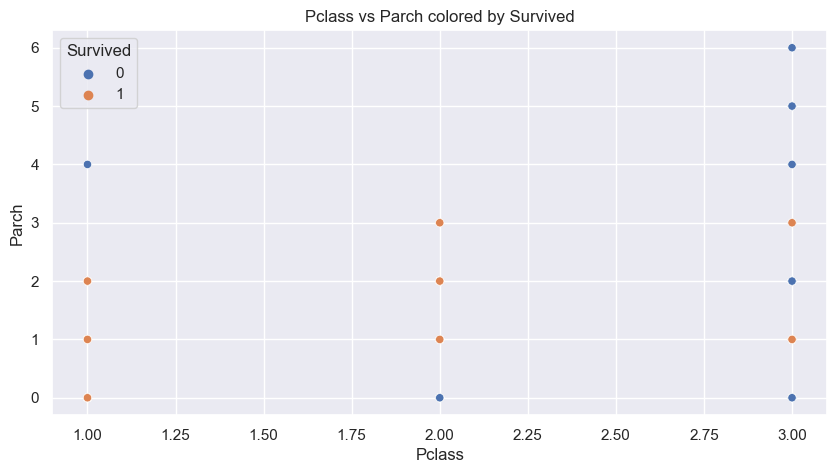

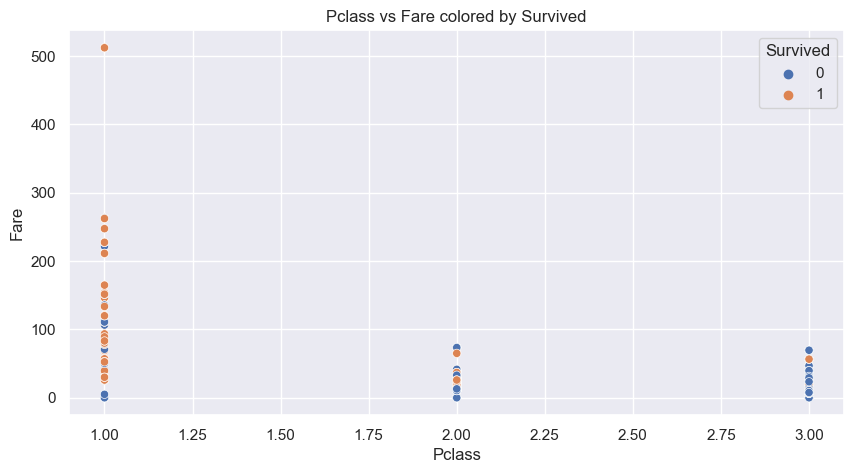

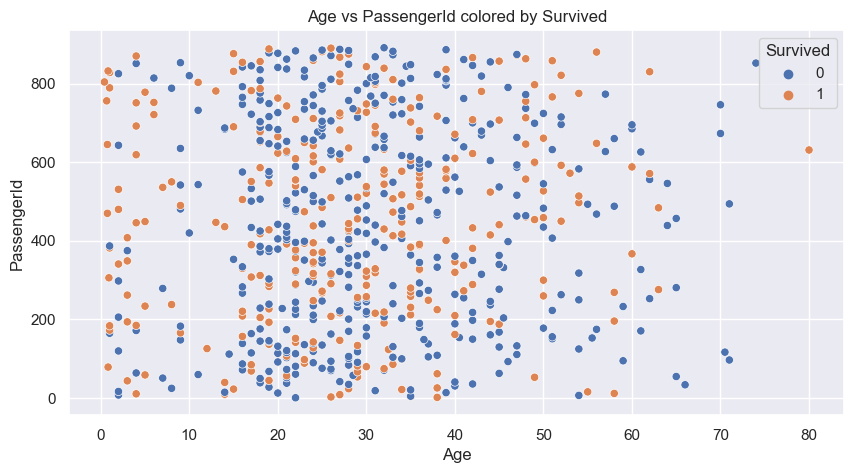

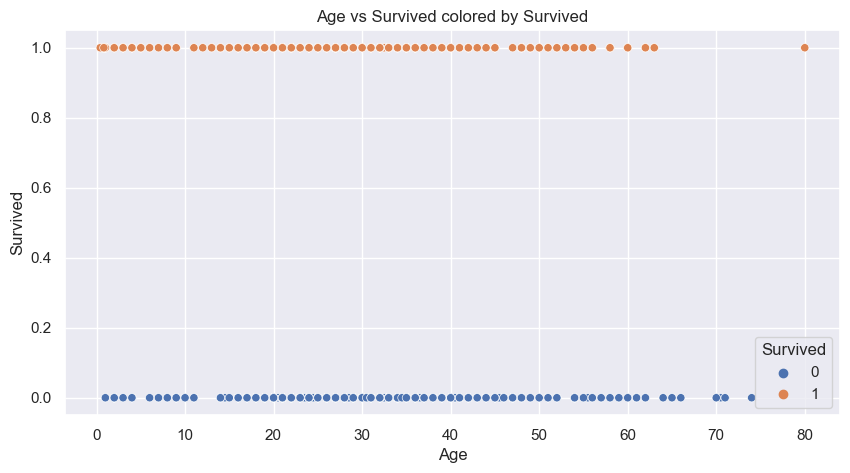

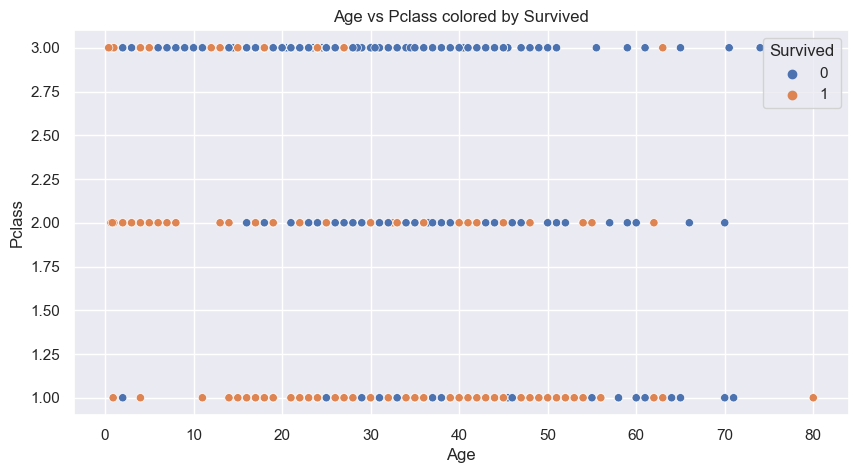

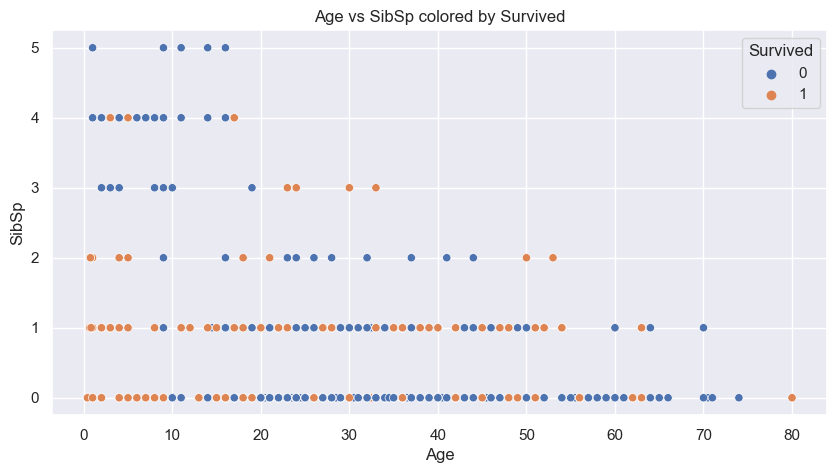

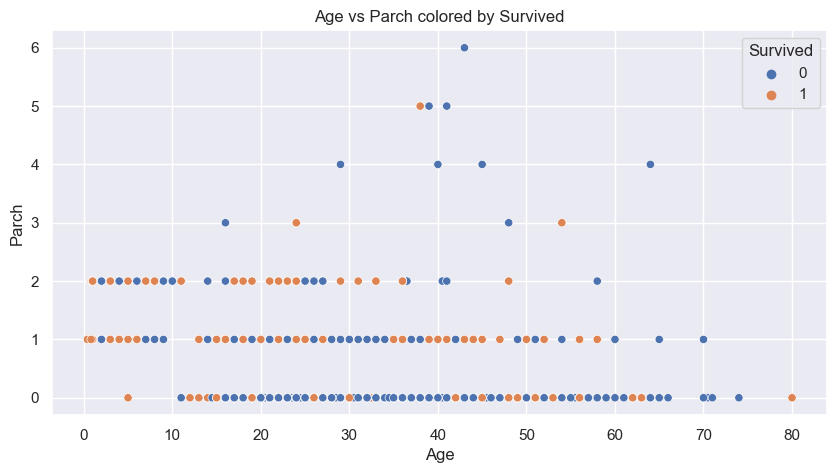

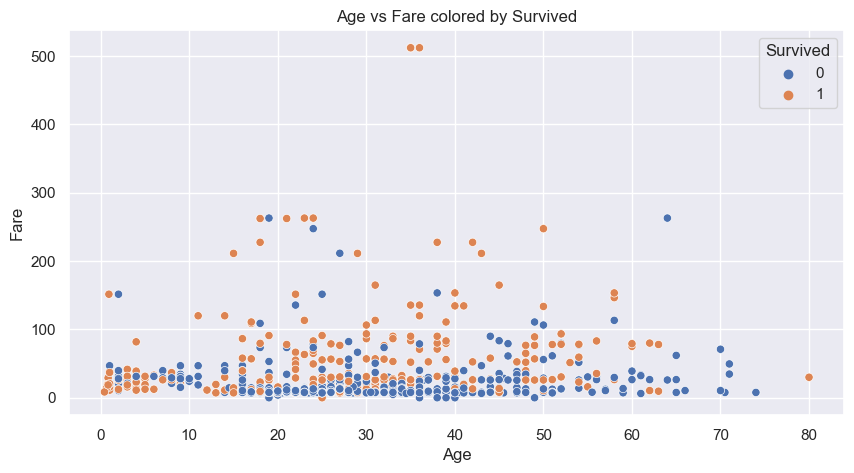

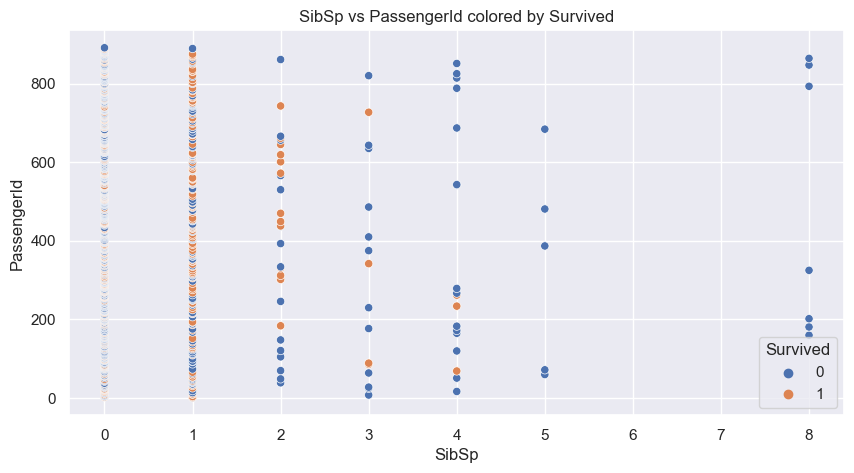

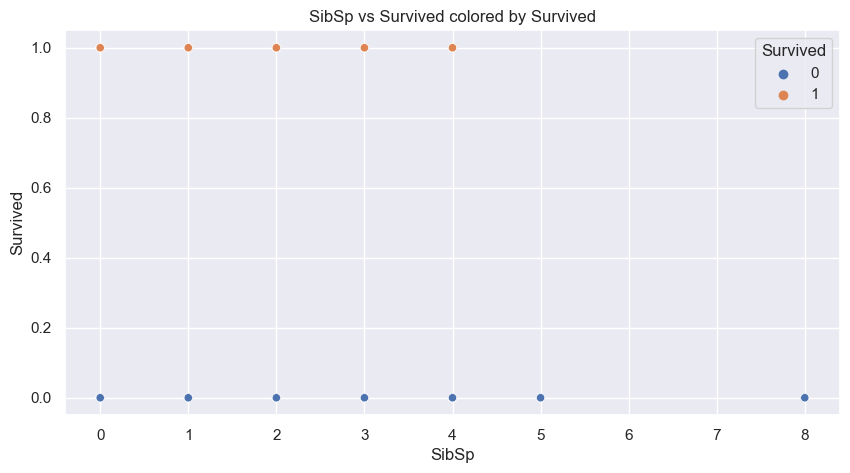

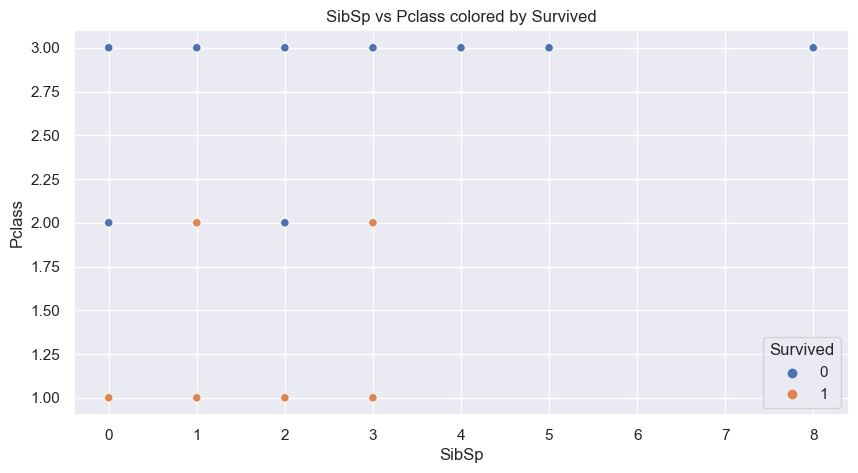

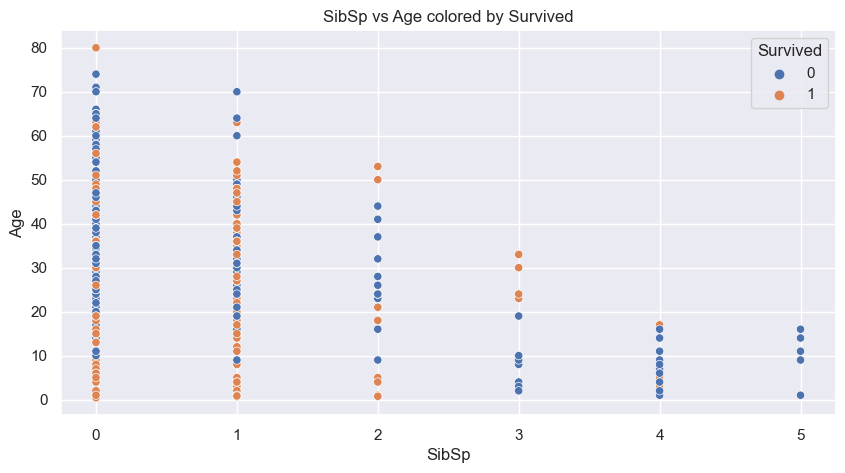

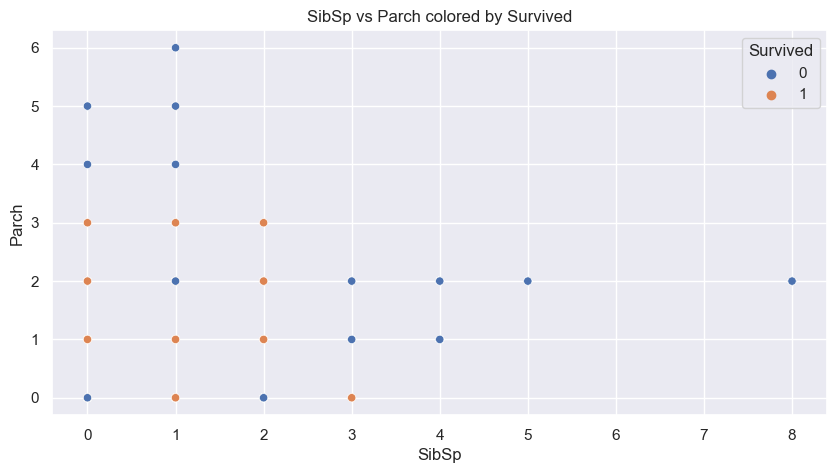

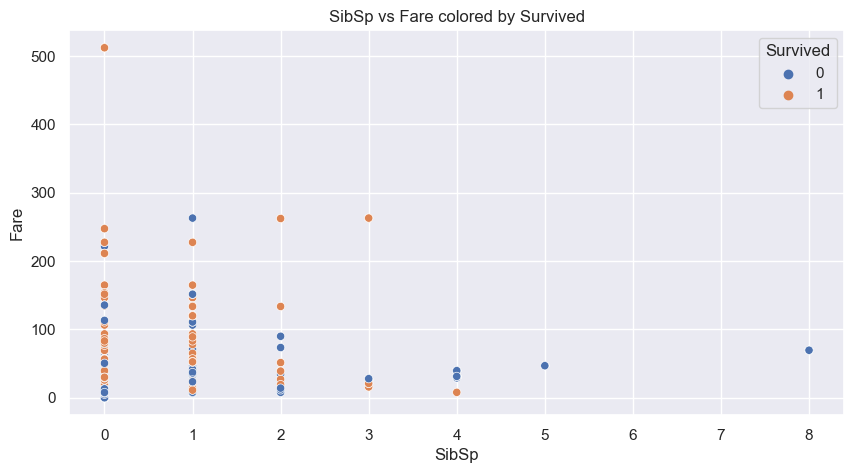

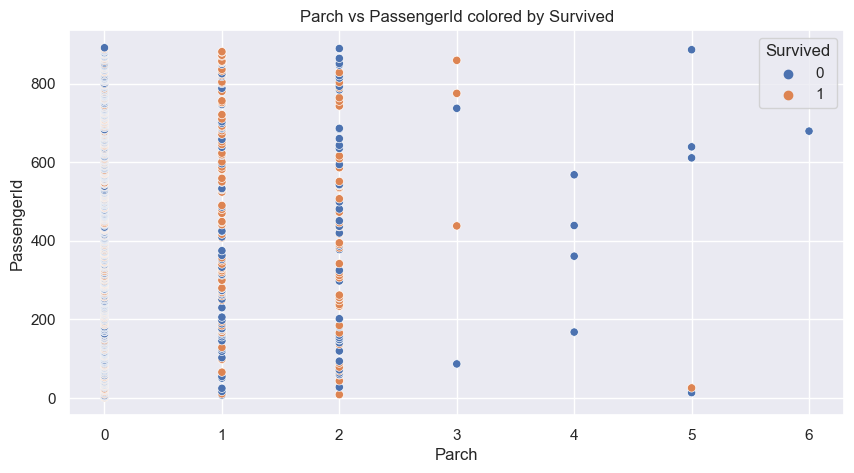

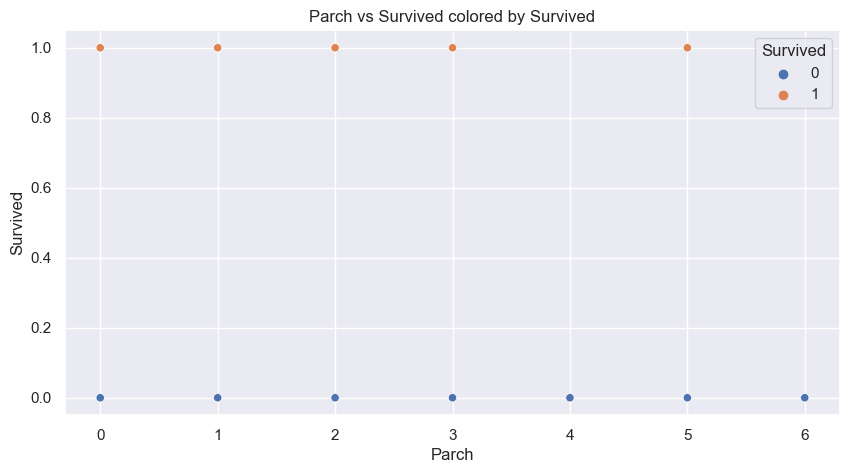

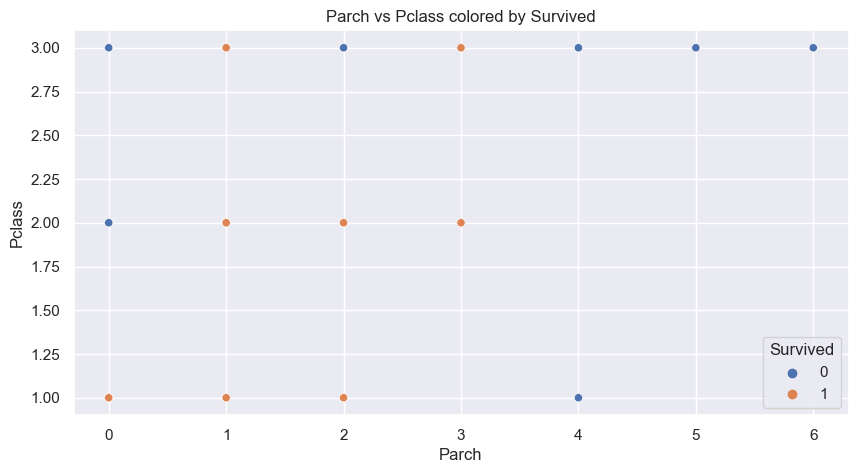

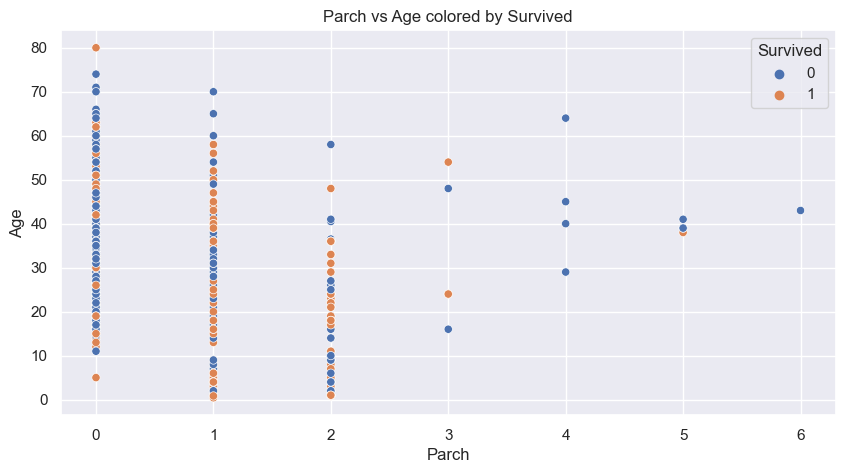

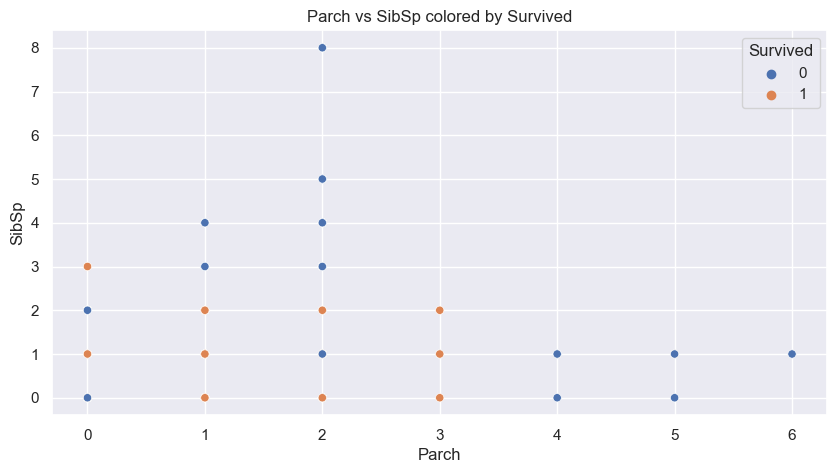

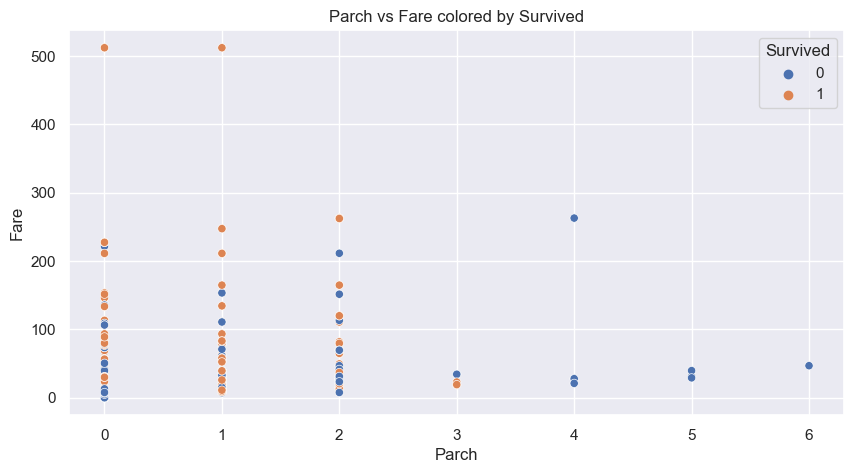

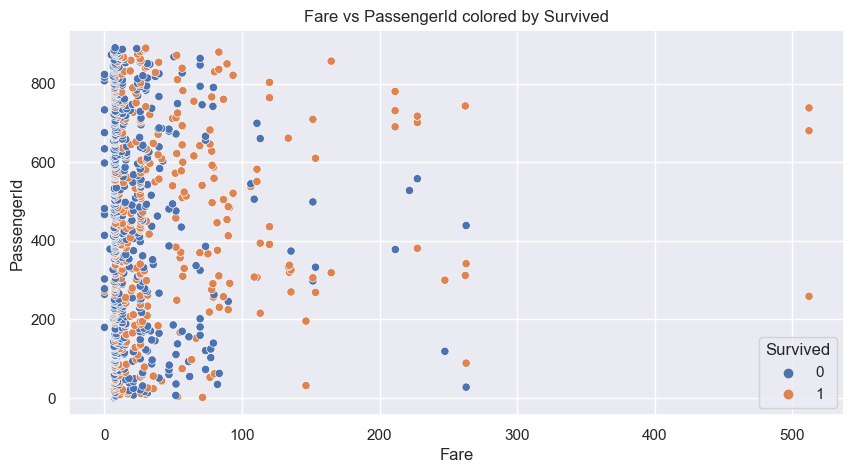

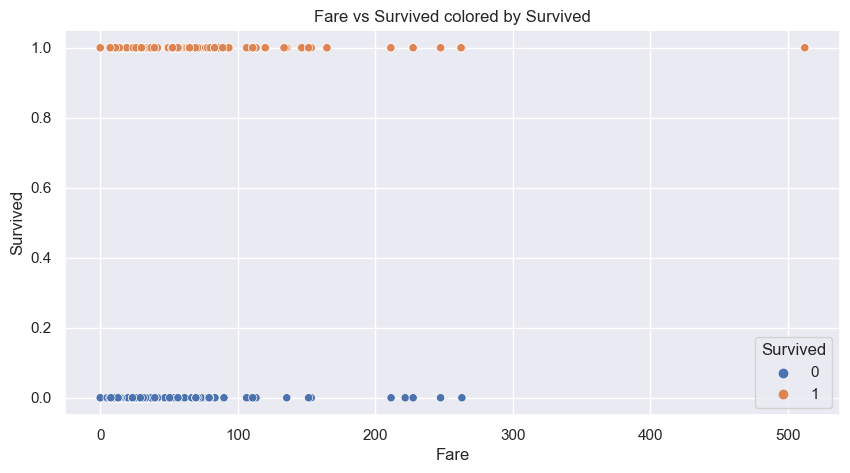

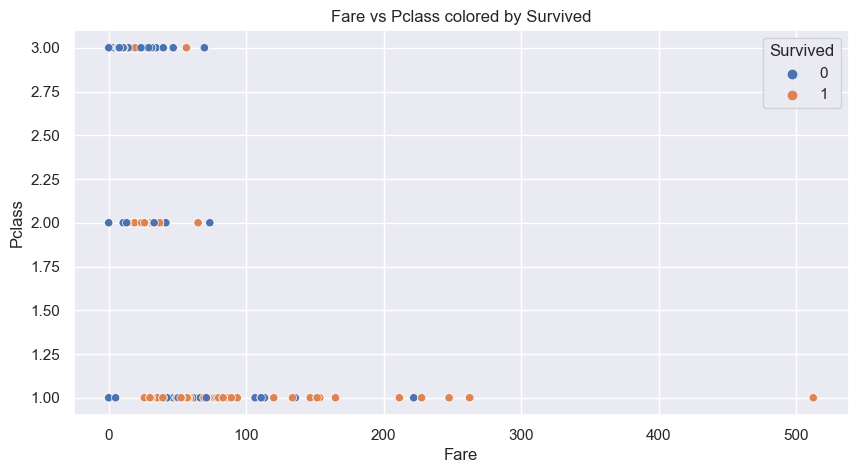

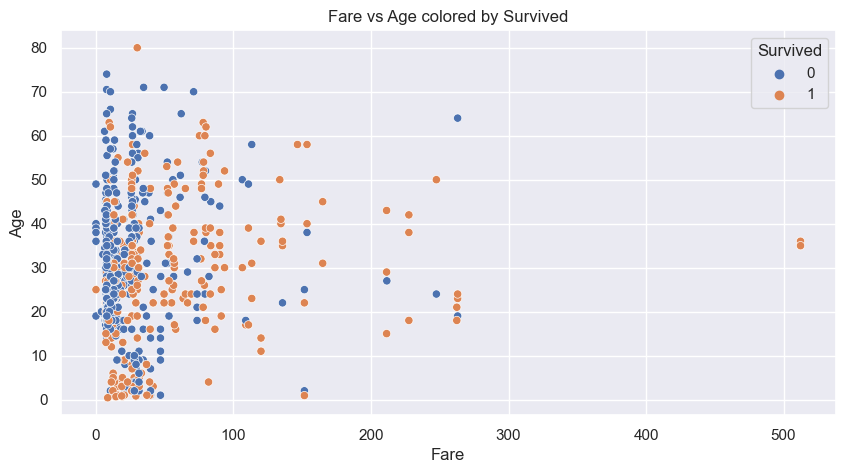

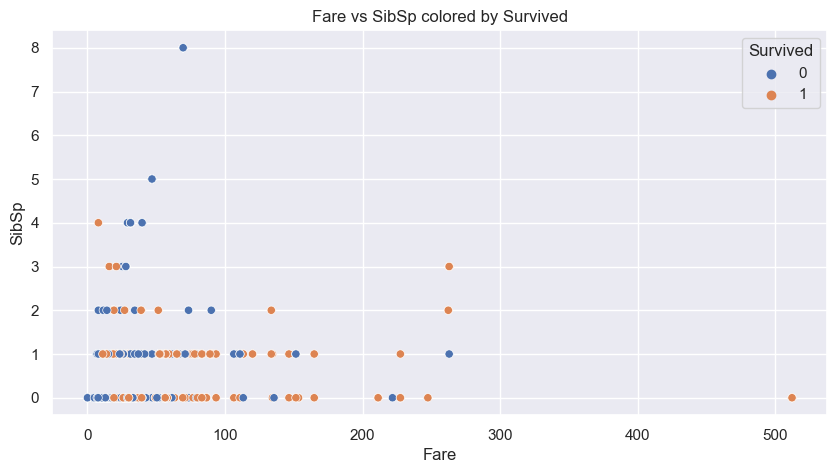

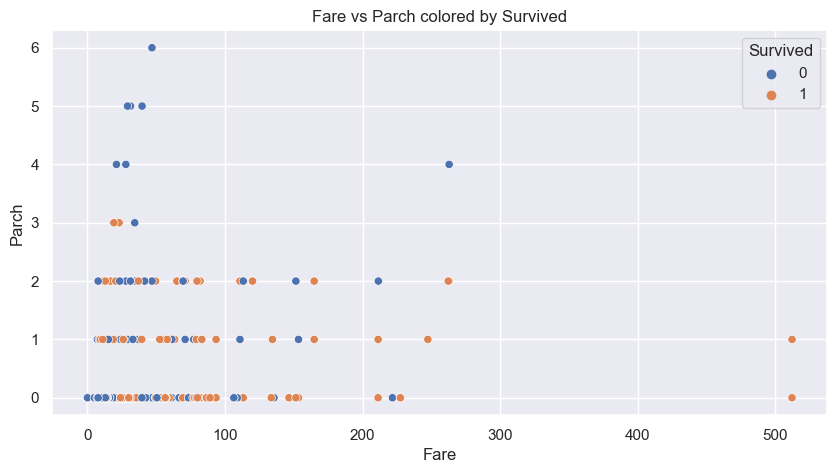

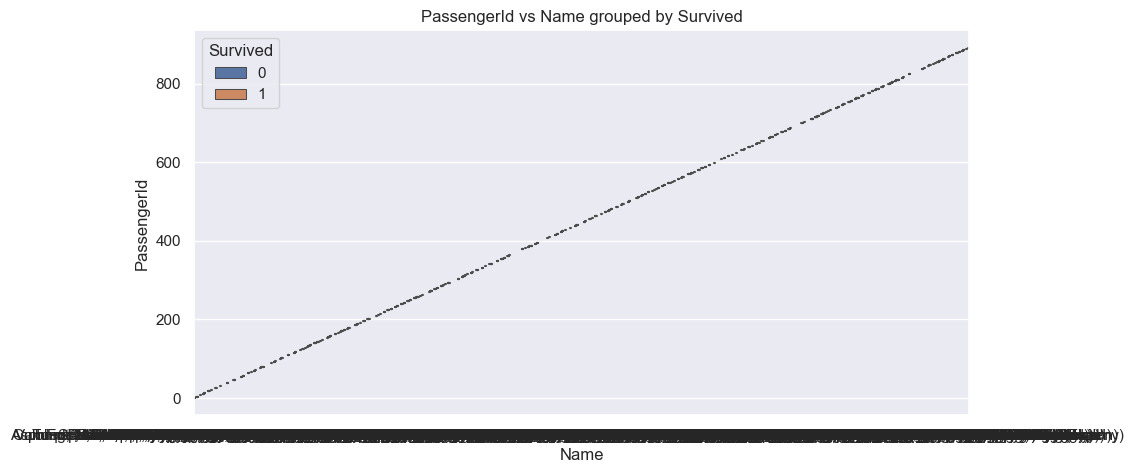

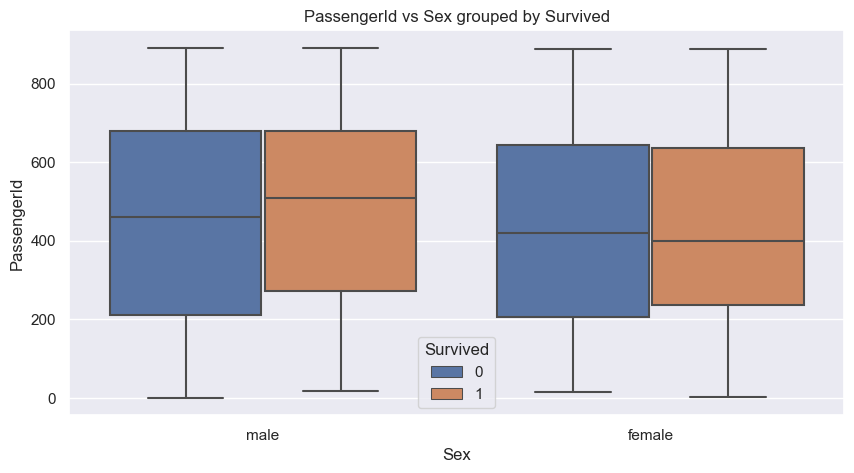

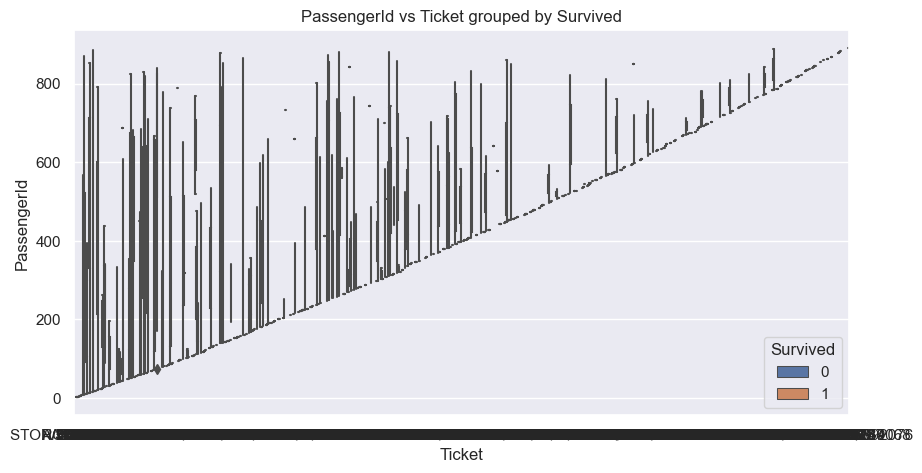

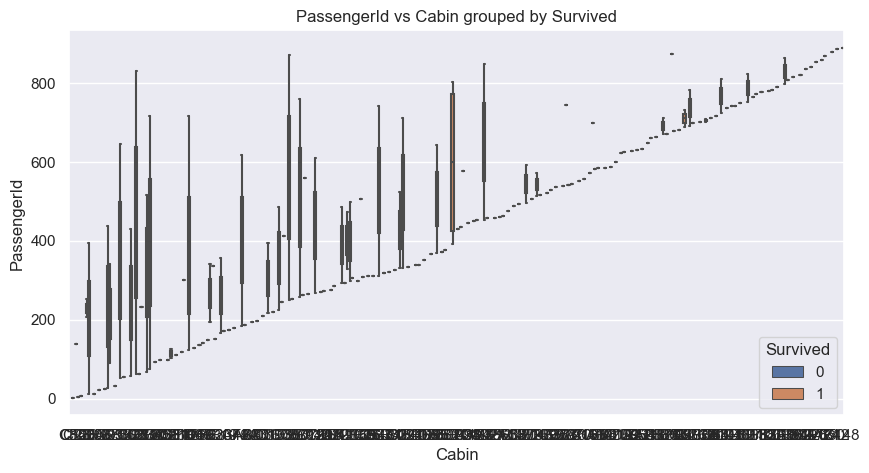

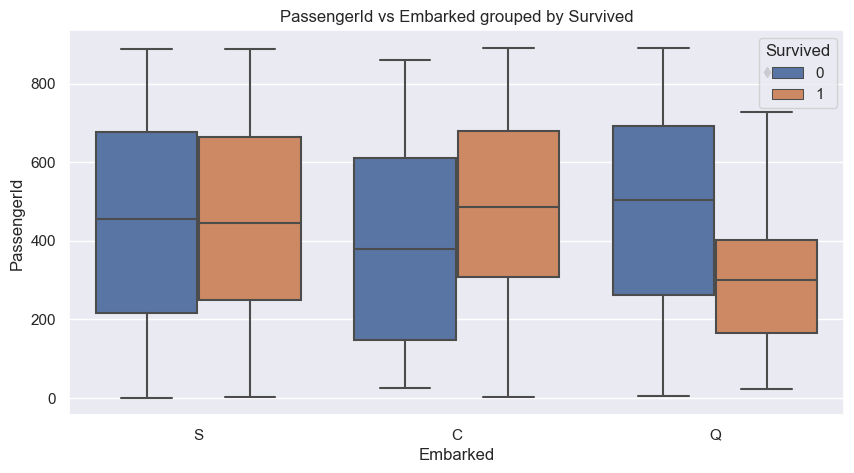

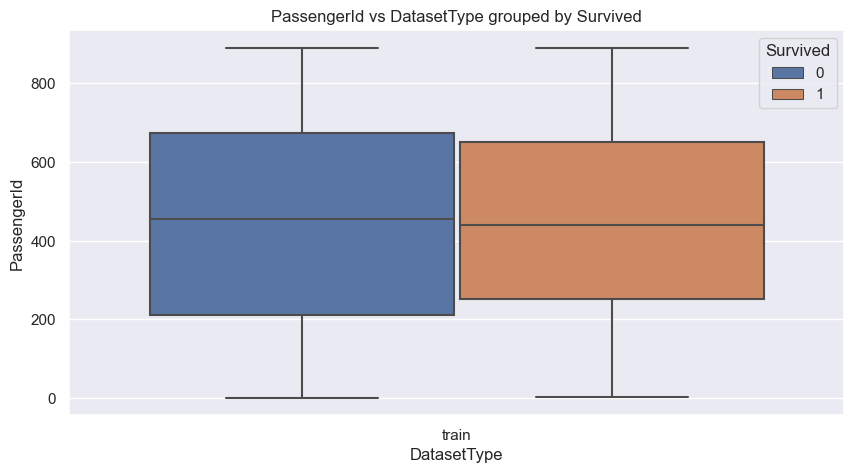

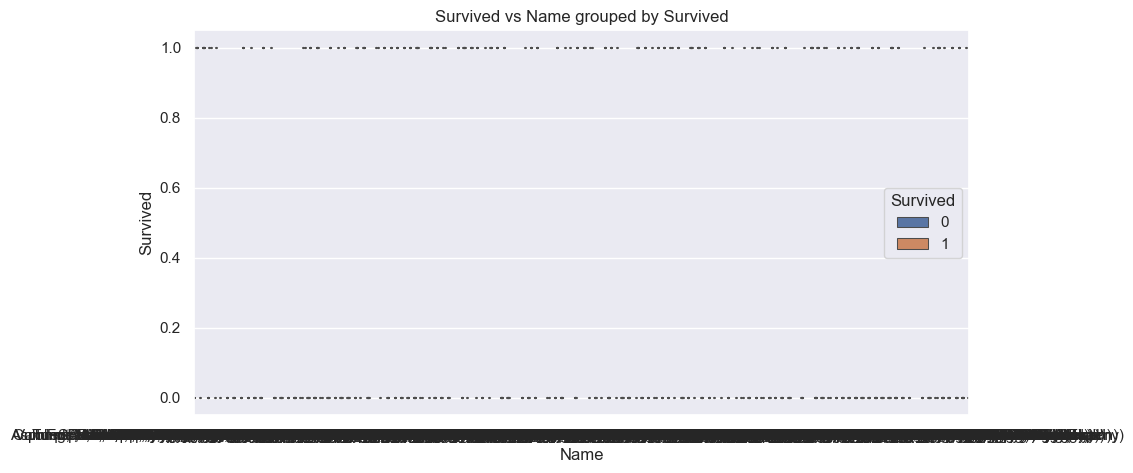

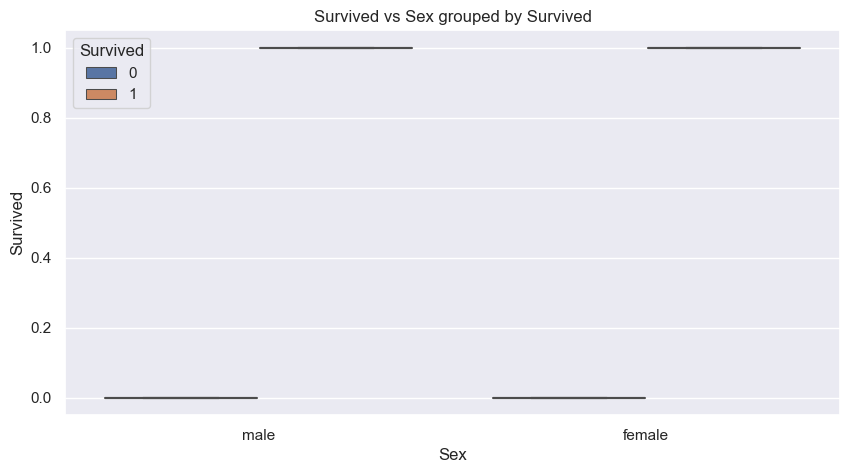

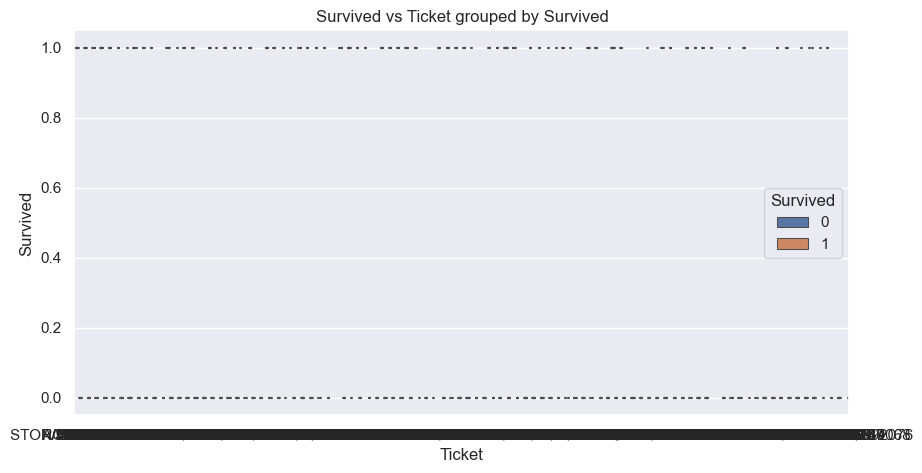

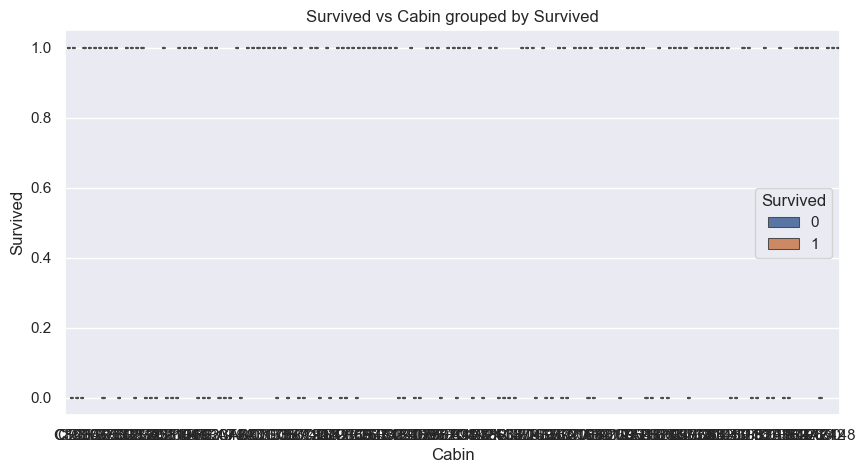

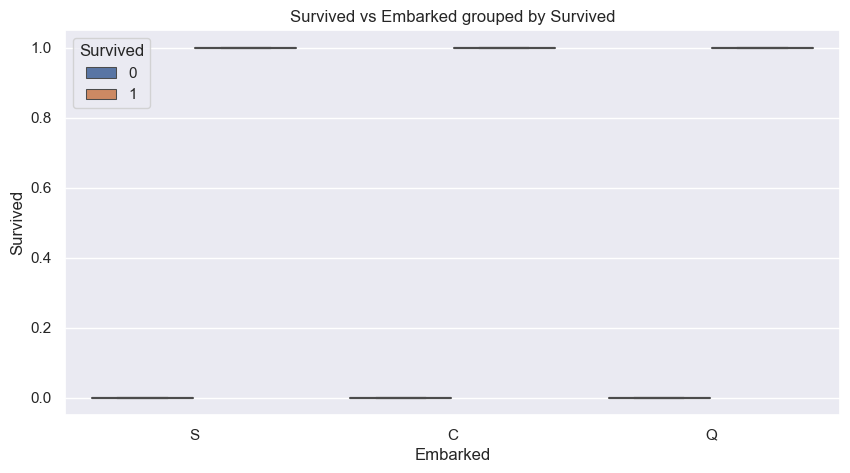

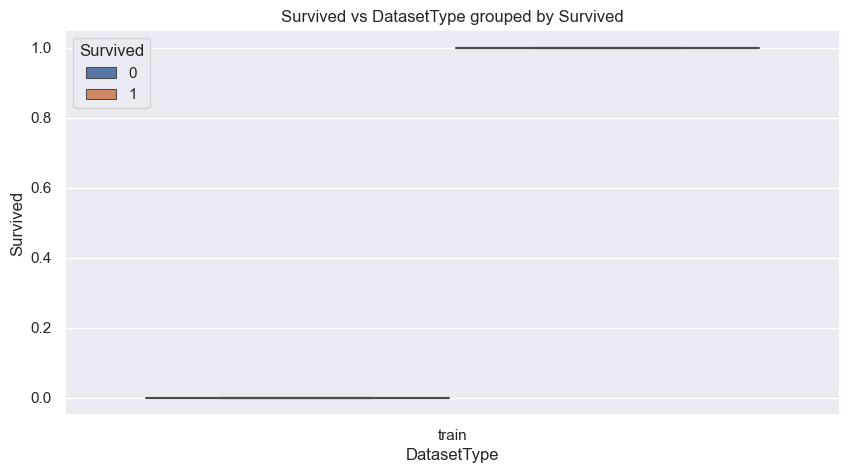

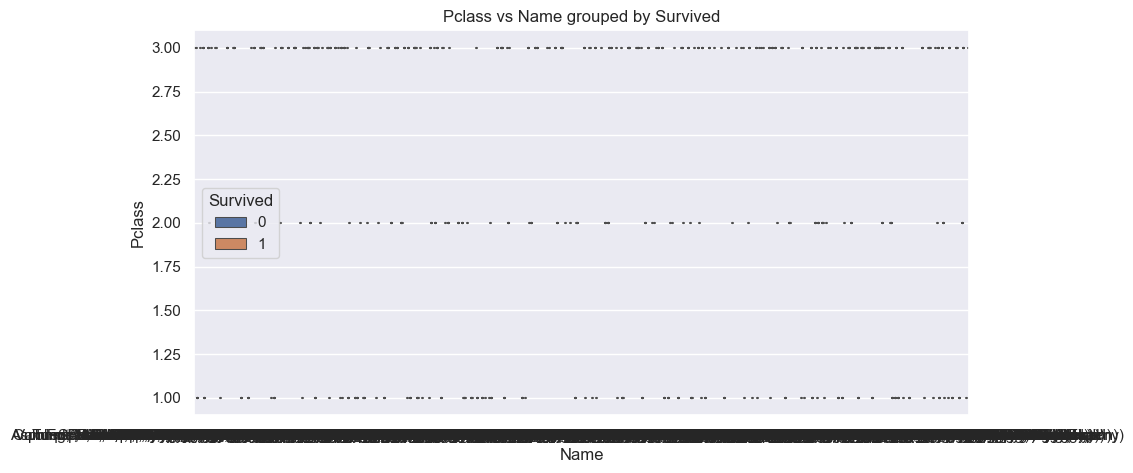

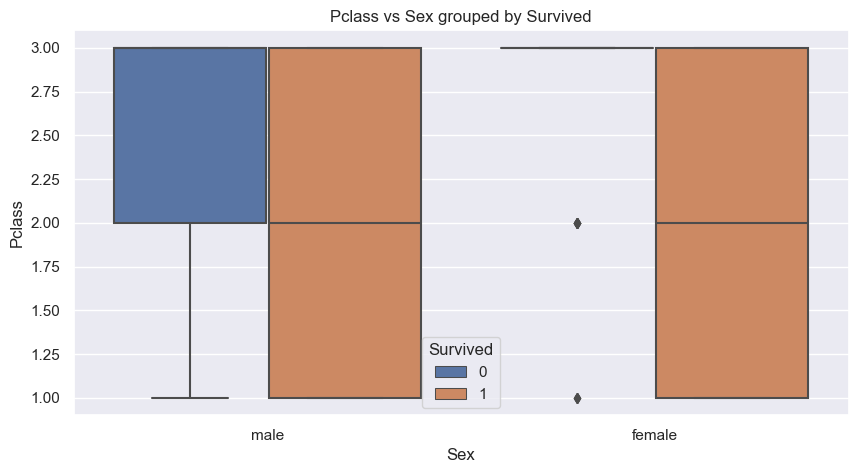

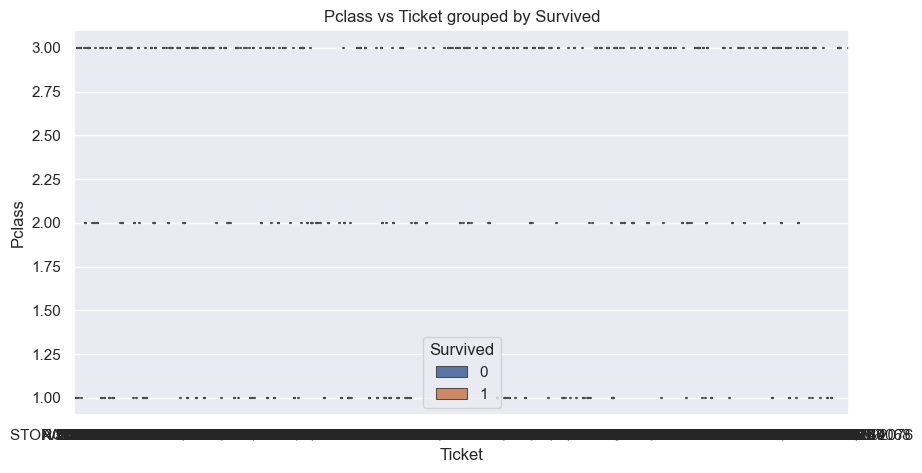

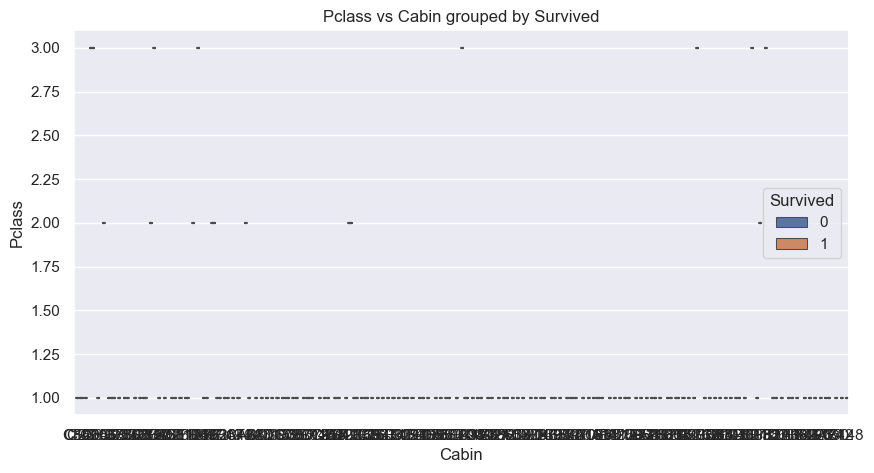

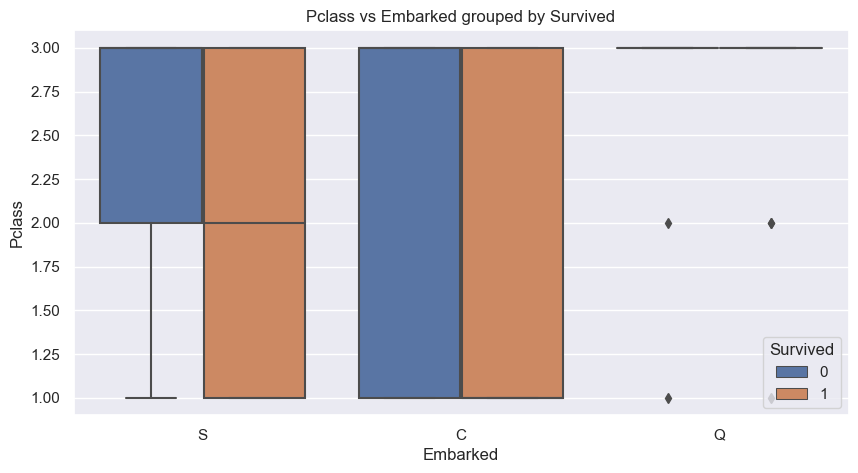

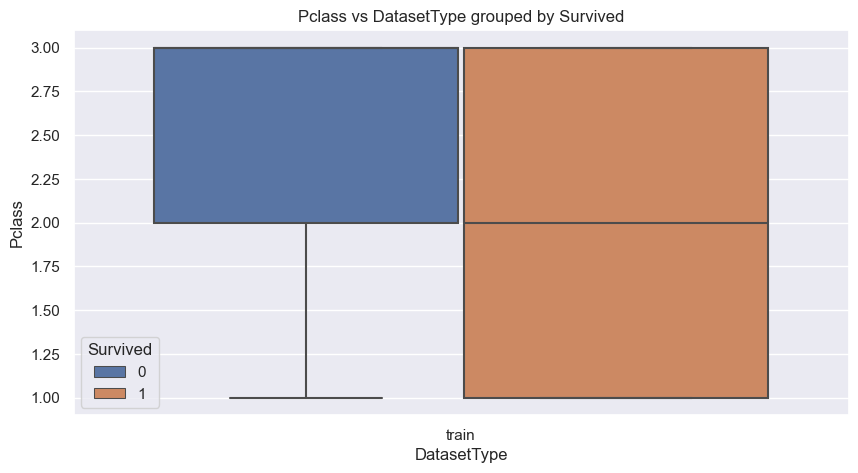

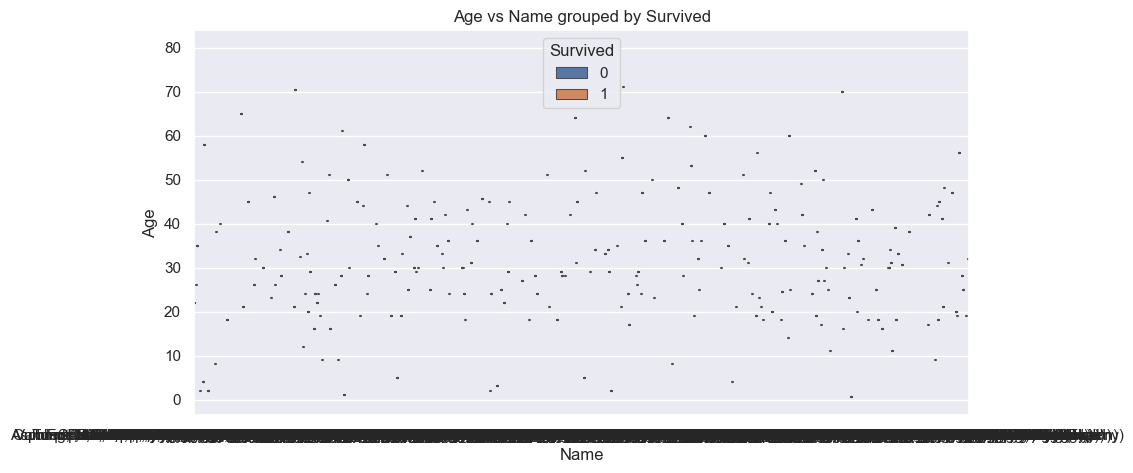

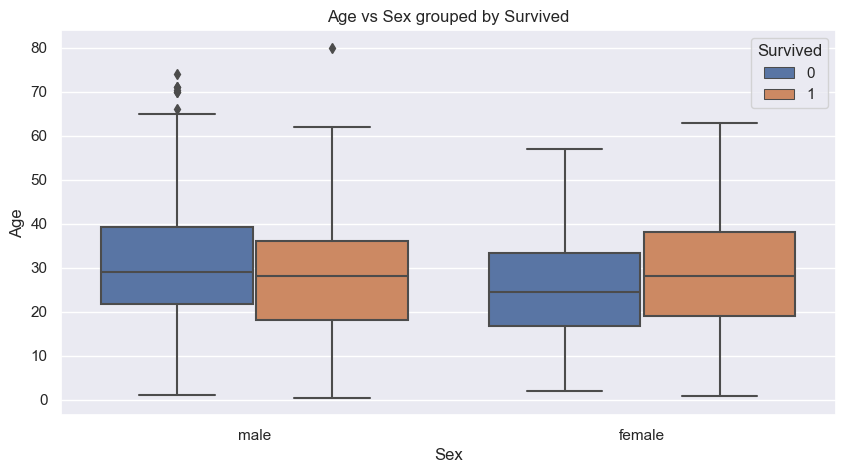

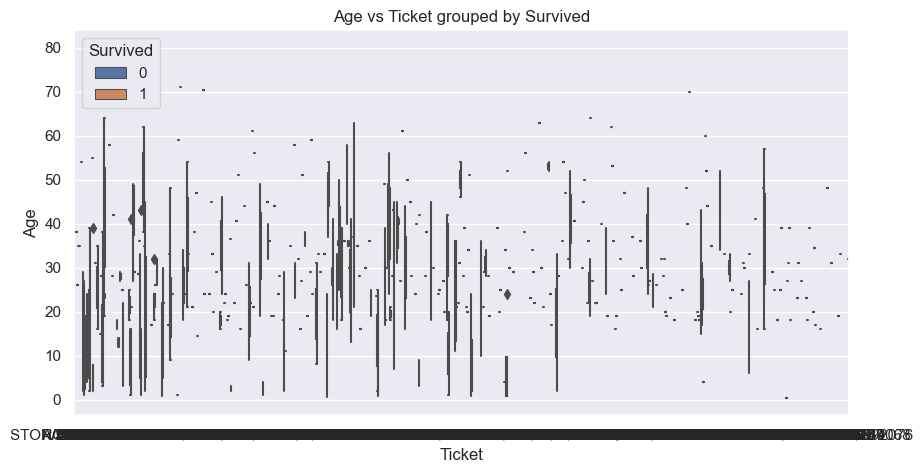

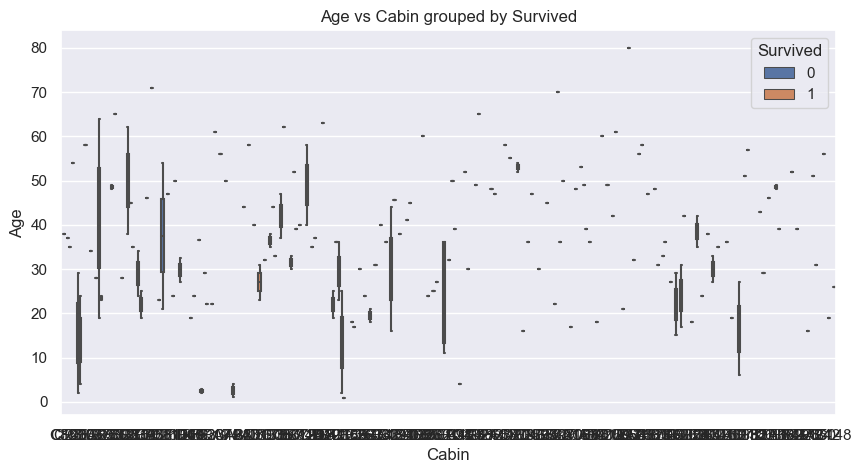

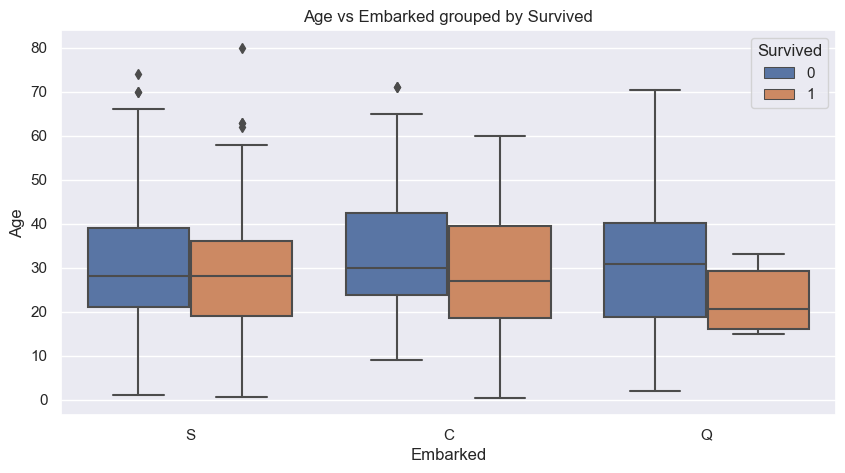

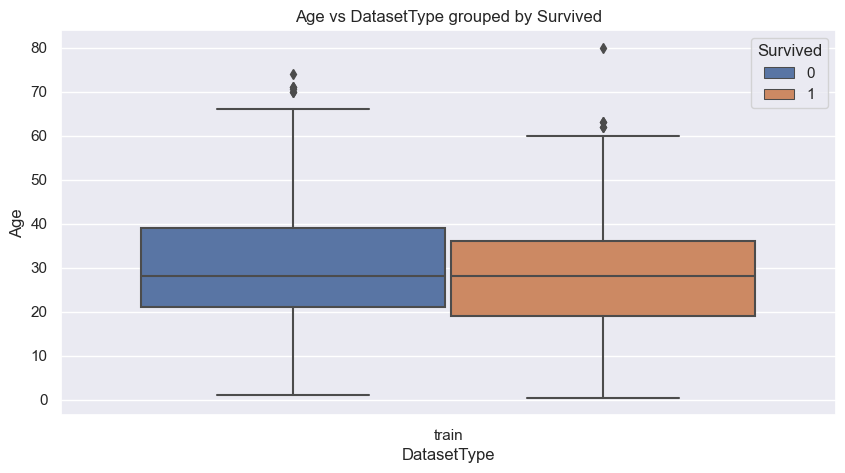

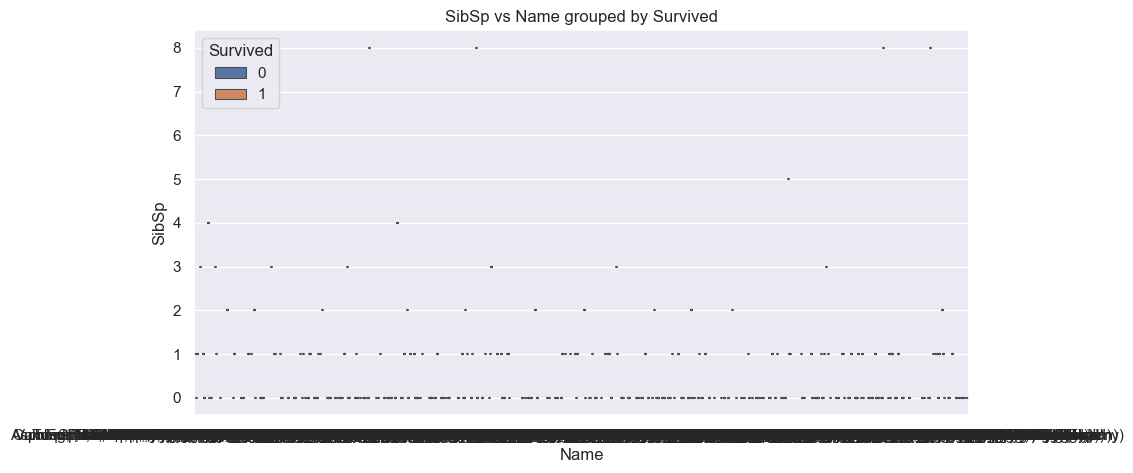

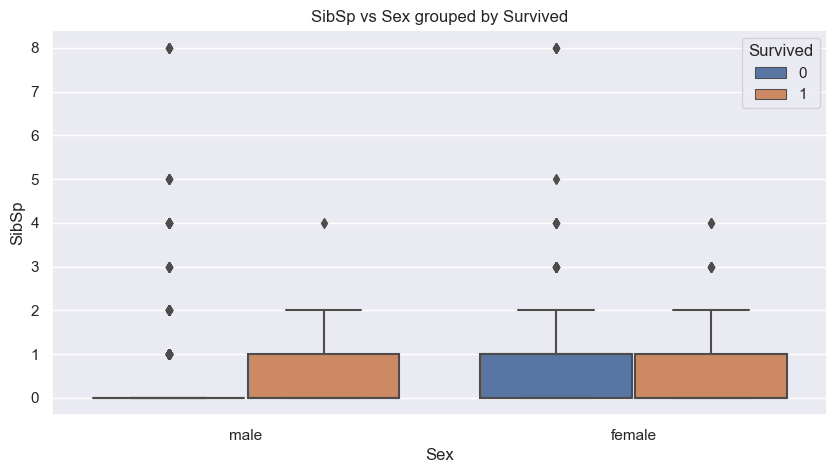

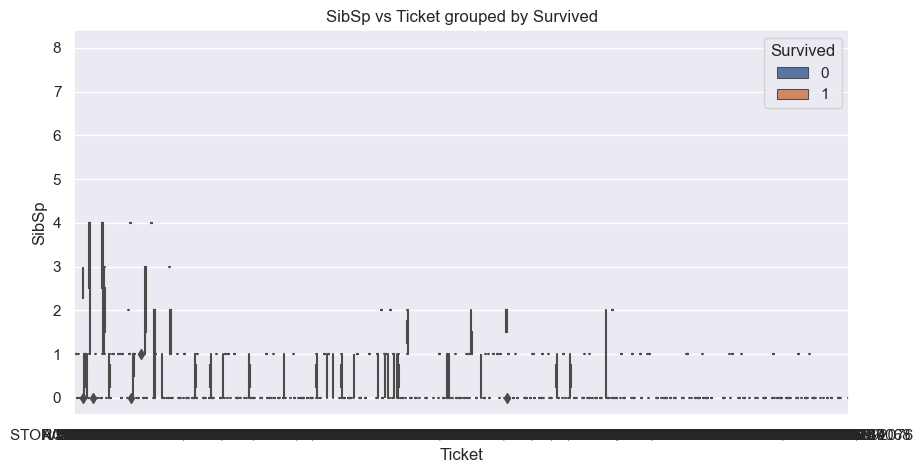

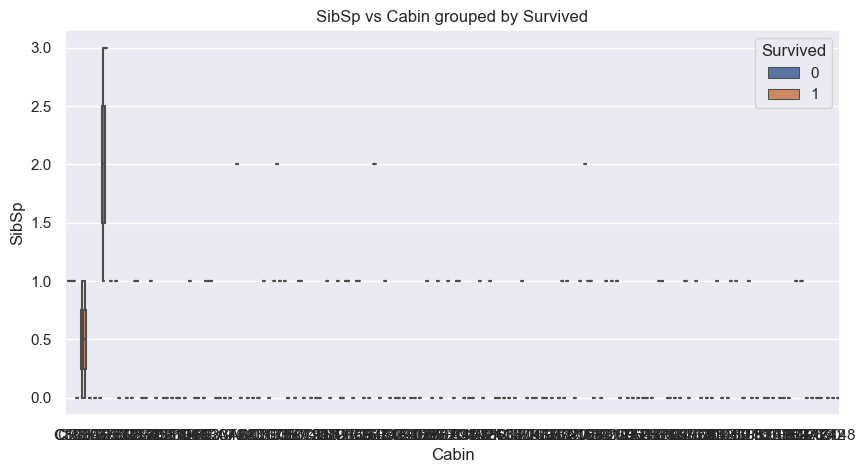

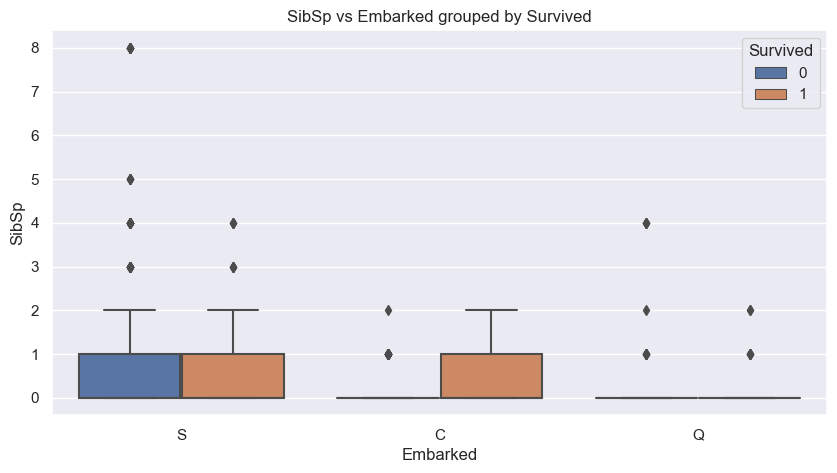

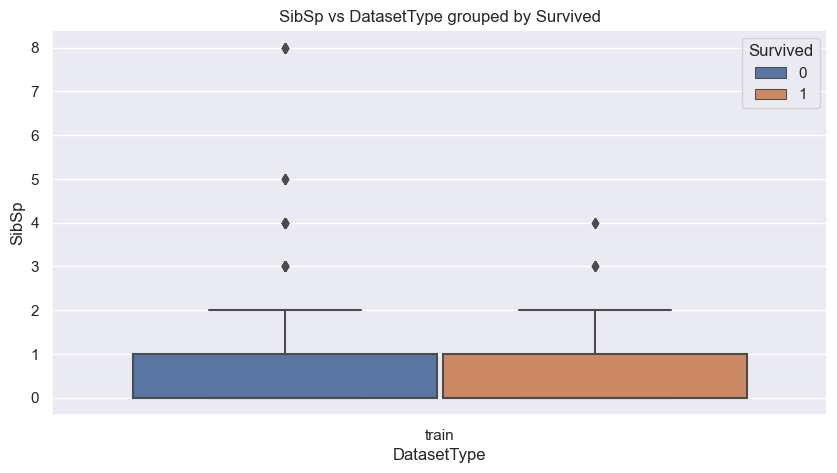

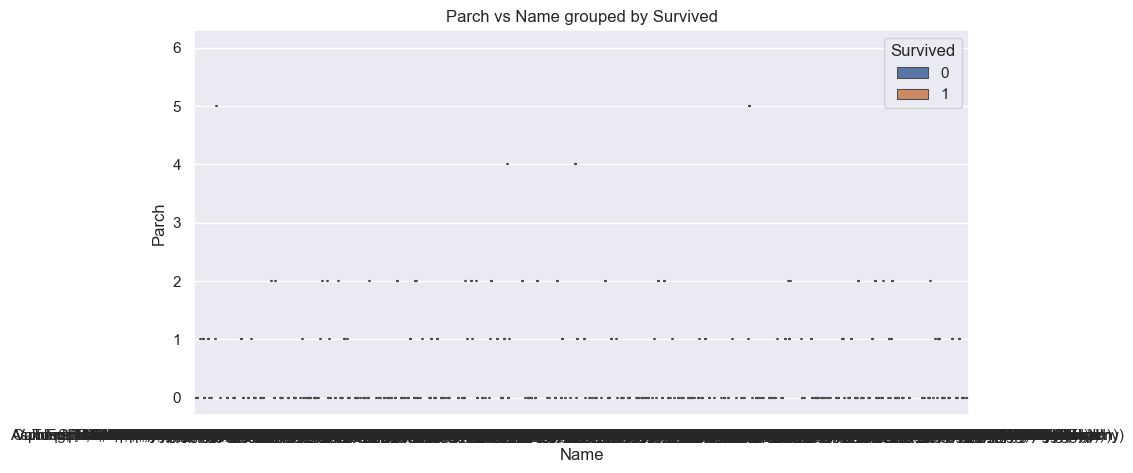

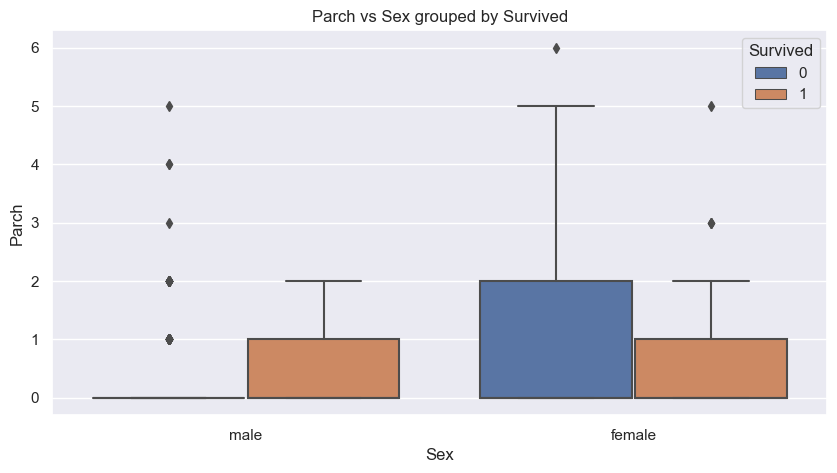

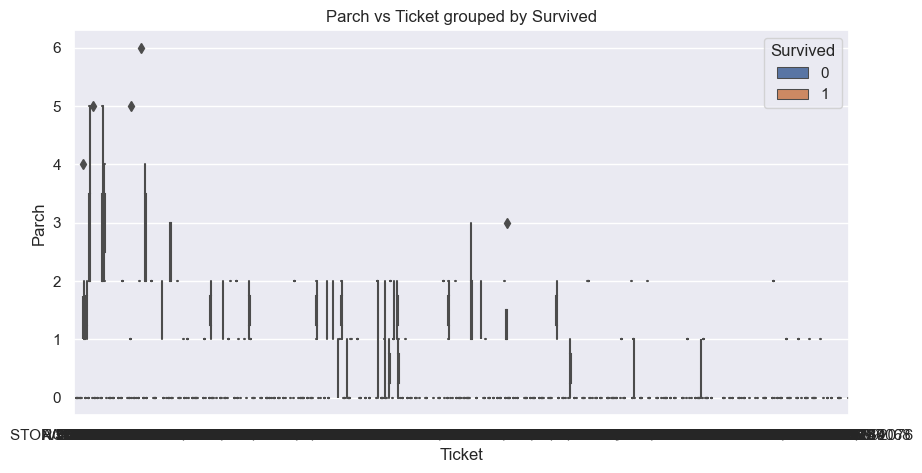

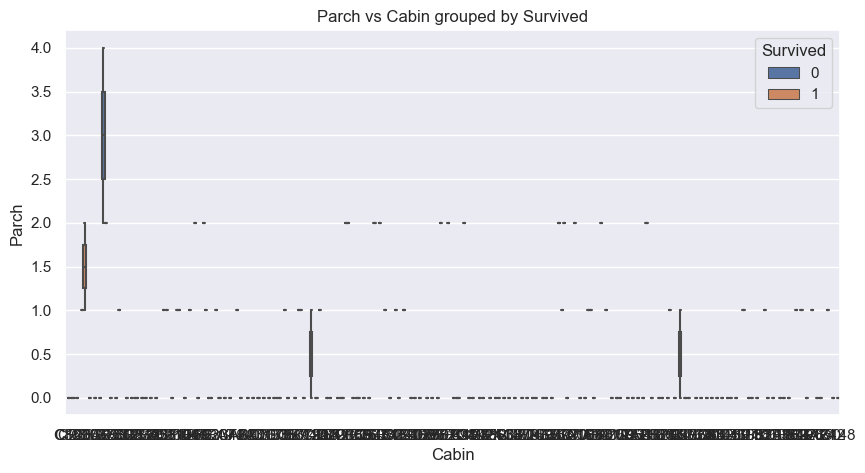

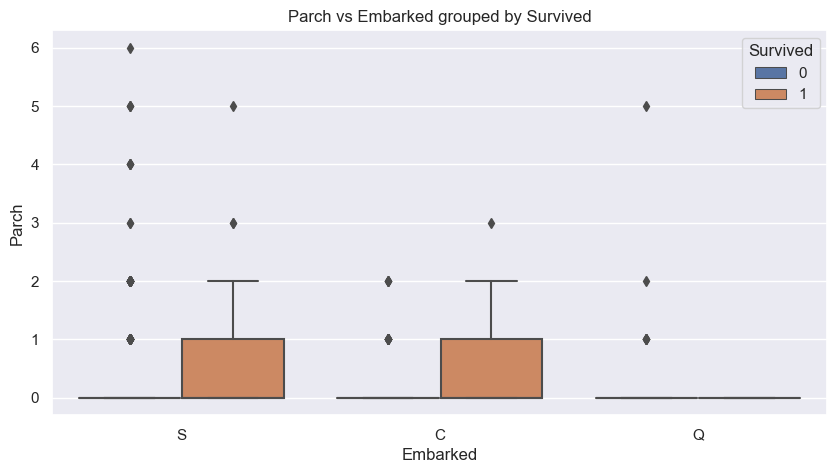

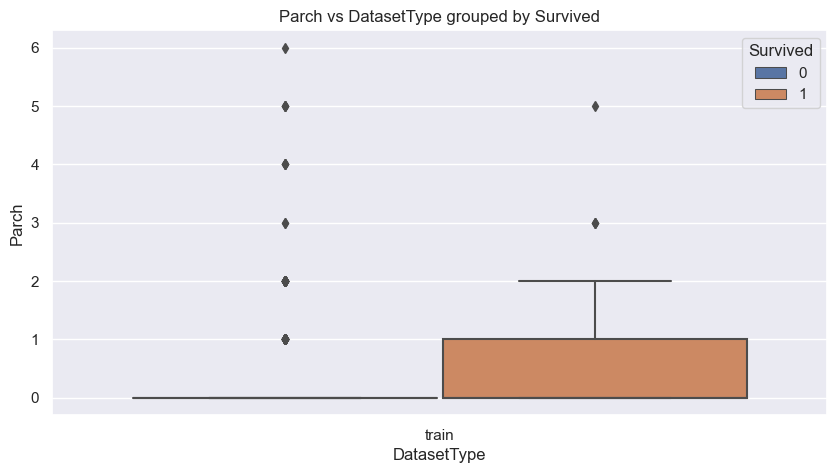

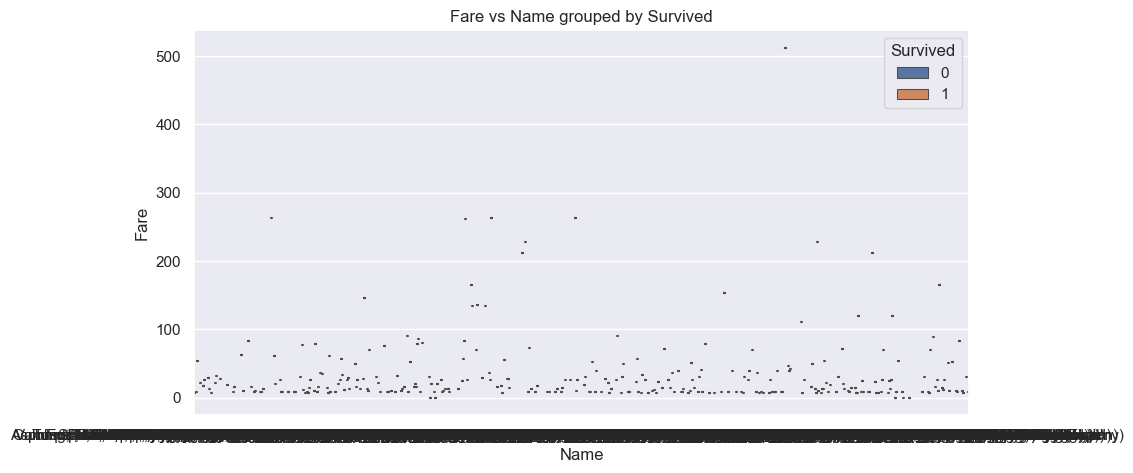

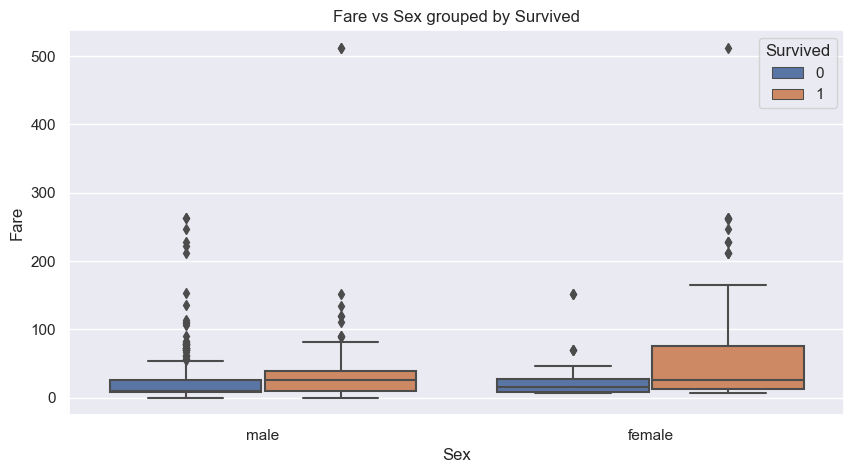

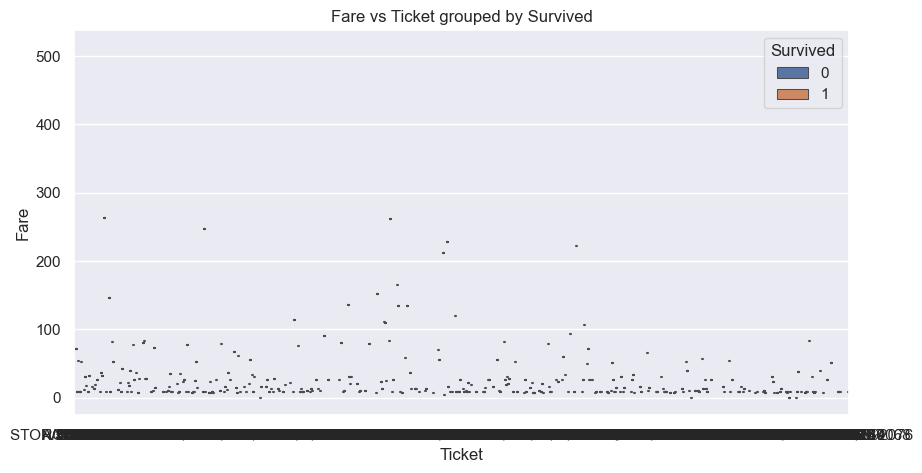

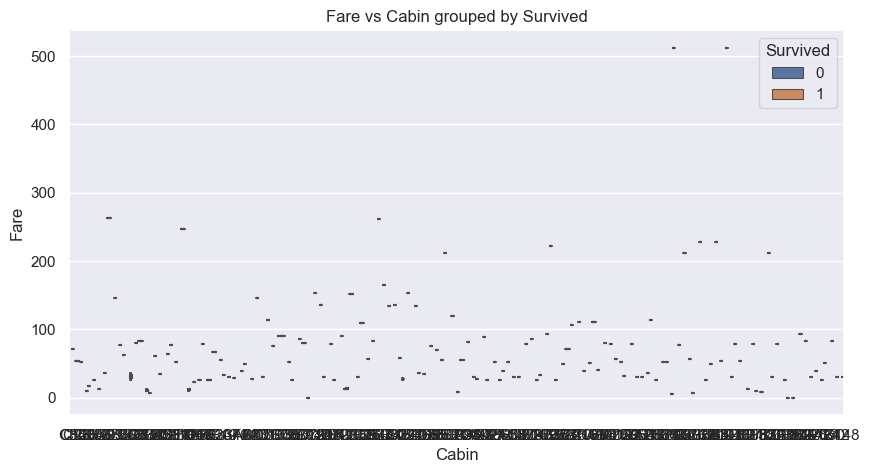

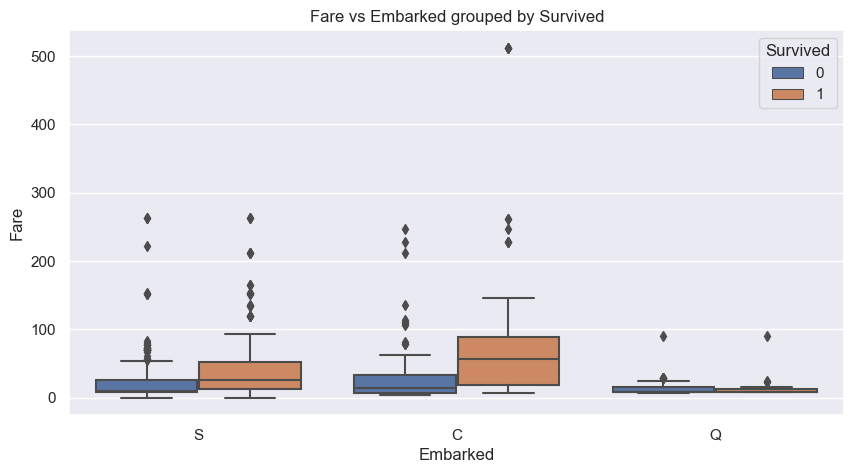

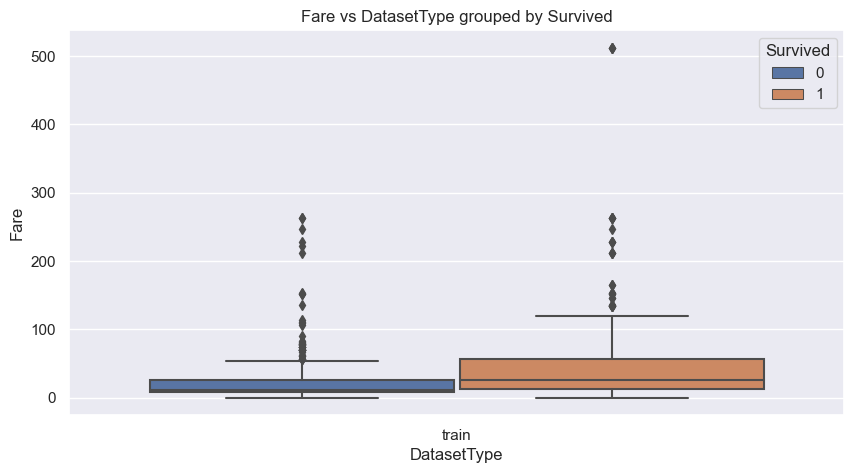

In [34]:
def bivariate_analysis(df, target):
    # Pairs of features (combination of numerical and categorical)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    # Numerical vs Numerical
    for col1 in num_cols:
        for col2 in num_cols:
            if col1 != col2:
                plt.figure(figsize=(10, 5))
                sns.scatterplot(x=col1, y=col2, hue=target, data=df)
                plt.title(f'{col1} vs {col2} colored by {target}')
                plt.show()

    # Numerical vs Categorical
    for num_col in num_cols:
        for cat_col in cat_cols:
            plt.figure(figsize=(10, 5))
            sns.boxplot(x=cat_col, y=num_col, hue=target, data=df)
            plt.title(f'{num_col} vs {cat_col} grouped by {target}')
            plt.show()

bivariate_analysis(train, "Survived") 

# **Modeling**

## **1 Catboost (sore 0.79)**

In [35]:
train_processed = combined[combined["DatasetType"] == "train"].drop(["DatasetType"], axis=1)
test_processed = combined[combined["DatasetType"] == "test"].drop(["DatasetType", "Survived"], axis=1)

In [36]:
# Prepare data
X = train_processed.drop(["Survived", "Name", "Ticket", "Cabin", "Title", "AgeGroup"], axis=1)
y = train_processed["Survived"]
X_test = test_processed.drop(["Name", "Ticket", "Cabin", "Title", "AgeGroup"], axis=1)

# Train-Test Split for Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
X_train

PassengerId Pclass     Sex       Age  SibSp  Parch      Fare Embarked  \
331         332      1    male  45.50000      0      0   28.5000        S   
733         734      2    male  23.00000      0      0   13.0000        S   
382         383      3    male  32.00000      0      0    7.9250        S   
704         705      3    male  26.00000      1      0    7.8542        S   
813         814      3  female   6.00000      4      2   31.2750        S   
..          ...    ...     ...       ...    ...    ...       ...      ...   
106         107      3  female  21.00000      0      0    7.6500        S   
270         271      1    male  38.29776      0      0   31.0000        S   
860         861      3    male  41.00000      2      0   14.1083        S   
435         436      1  female  14.00000      1      2  120.0000        S   
102         103      1    male  21.00000      0      1   77.2875        S   

      FamilyName  TitleEncoded  ...  DetailedPassengerStatus GroupSize  Deck  \
331      Partner             2  ...   Middle-Class Passenger         1     C   
733     Berriman             2  ...   Middle-Class Passenger         1     U   
382     Tikkanen             2  ...                  Migrant         1     U   
704       Hansen             2  ...                  Migrant         1     U   
813    Andersson             1  ...      Low-Class Passenger         7     U   
..           ...           ...  ...                      ...       ...   ...   
106  Salkjelsvik             1  ...                  Migrant         1     U   
270       Cairns             2  ...   Middle-Class Passenger         2     U   
860       Hansen             2  ...      Low-Class Passenger         2     U   
435       Carter             1  ...        Wealthy Passenger         4     B   
102        White             2  ...   Middle-Class Passenger         2     D   

    IsAlone FarePerPerson NameLength  EmbarkedCategory Pclass_Fare  \
331       1     28.500000         19       Southampton     28.5000   
733       1     13.000000         26       Southampton     26.0000   
382       1      7.925000         18       Southampton     23.7750   
704       0      7.854200         23       Southampton     23.5626   
813       0      4.467857         34       Southampton     93.8250   
..      ...           ...        ...               ...         ...   
106       1      7.650000         32       Southampton     22.9500   
270       1     15.500000         21       Southampton     31.0000   
860       0      7.054150         23       Southampton     42.3249   
435       0     30.000000         25       Southampton    120.0000   
102       0     38.643750         25       Southampton     77.2875   

    Title_AgeGroup  AgeGroupEncoded  
331       Mr_Adult                0  
733       Mr_Adult                0  
382       Mr_Adult                0  
704       Mr_Adult                0  
813     Miss_Child                1  
..             ...              ...  
106     Miss_Adult                0  
270     Mr_Unknown                4  
860       Mr_Adult                0  
435      Miss_Teen                3  
102       Mr_Adult                0  

[712 rows x 25 columns]

In [37]:
# Train CatBoost Model
cat_features = X.select_dtypes(include=["object","category"]).columns.tolist()  # Categorical columns
catboost_model = CatBoostClassifier(iterations=7000, learning_rate=0.1, depth=6, random_state=42, verbose=100)

# Train the model
catboost_model.fit(X_train, y_train, cat_features=cat_features)

# Evaluate Model
y_pred = catboost_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

0:	learn: 0.6300281	total: 196ms	remaining: 22m 49s
100:	learn: 0.2472073	total: 4.41s	remaining: 5m
200:	learn: 0.1602840	total: 8.55s	remaining: 4m 49s
300:	learn: 0.1100931	total: 12.4s	remaining: 4m 35s
400:	learn: 0.0783205	total: 15.9s	remaining: 4m 21s
500:	learn: 0.0602629	total: 19.6s	remaining: 4m 14s
600:	learn: 0.0476147	total: 23.2s	remaining: 4m 6s
700:	learn: 0.0389746	total: 26.7s	remaining: 3m 59s
800:	learn: 0.0321624	total: 30.3s	remaining: 3m 54s
900:	learn: 0.0281256	total: 33.9s	remaining: 3m 49s
1000:	learn: 0.0249547	total: 37.5s	remaining: 3m 44s
1100:	learn: 0.0214400	total: 41.4s	remaining: 3m 41s
1200:	learn: 0.0196531	total: 45.3s	remaining: 3m 38s
1300:	learn: 0.0180111	total: 49s	remaining: 3m 34s
1400:	learn: 0.0168647	total: 52.8s	remaining: 3m 31s
1500:	learn: 0.0153221	total: 56.5s	remaining: 3m 26s
1600:	learn: 0.0144209	total: 1m	remaining: 3m 22s
1700:	learn: 0.0134120	total: 1m 4s	remaining: 3m 19s
1800:	learn: 0.0126900	total: 1m 7s	remaining: 3m

In [46]:
cat_features

['PassengerId',
 'Pclass',
 'Sex',
 'Embarked',
 'FamilyName',
 'FamilyGroup',
 'TicketPrefix',
 'PassengerStatus',
 'DetailedPassengerStatus',
 'Deck',
 'IsAlone',
 'EmbarkedCategory',
 'Title_AgeGroup']

In [38]:
# Predict on Test Dataset
#test_predictions = catboost_model.predict(test_processed.drop(["Name", "Ticket", "Cabin", "Title", "AgeGroup"], axis=1))

# Convert predictions to integers (to avoid float values like 1.0, 0.0)
#test_predictions = test_predictions.astype(int)

# Create Submission File
#submission = pd.DataFrame({"PassengerId": test_processed["PassengerId"], "Survived": test_predictions})
#submission.to_csv("catboost_submission.csv", index=False)

#print("\nKaggle submission file 'catboost_submission.csv' created.")


## **2 Advnaced Modeling (Score 0.81)**

In [39]:
# Convert object columns to category
for col in X_train.select_dtypes(include=["object"]).columns:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")

In [40]:
# Start H2O server
h2o.init()

# Convert Pandas DataFrame to H2O Frame
h2o_train = h2o.H2OFrame(X_train.join(y_train))
h2o_val = h2o.H2OFrame(X_val.join(y_val))

# Set response column as categorical
h2o_train["Survived"] = h2o_train["Survived"].asfactor()
h2o_val["Survived"] = h2o_val["Survived"].asfactor()

# Identify predictors and response
predictors = X_train.columns.tolist()
response = "Survived"

# Define Models and Hyperparameters
models_params = {
    "CatBoost": {
        "model": CatBoostClassifier(cat_features=cat_features, random_state=42, verbose=0),
        "params": {
            "iterations": [1000, 2000],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [4, 6, 8],
            "l2_leaf_reg": [1, 3, 5, 7],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, verbosity=0, random_state=42, enable_categorical=True, tree_method="hist"),
        "params": {
            "n_estimators": [500, 1000],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [4, 6, 8],
            "subsample": [0.6, 0.8, 1.0],
        },
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            "n_estimators": [500, 1000],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [4, 6, 8],
            "num_leaves": [20, 31, 50],
        },
    },
    "H2O_GBM": {
        "model": H2OGradientBoostingEstimator(),
        "params": {
            "ntrees": [100, 200, 500],
            "max_depth": [4, 6, 8],
            "learn_rate": [0.01, 0.05, 0.1],
        },
    },
}

# Train and Tune Models
results = []

for model_name, mp in models_params.items():
    print(f"Training and tuning {model_name}...")
    if model_name == "H2O_GBM":
        model = mp["model"]
        params = mp["params"]

        # Tune H2O GBM using grid search
        grid = h2o.grid.H2OGridSearch(
            model=model,
            hyper_params=params,
            search_criteria={"strategy": "RandomDiscrete", "max_models": 10, "seed": 42},
        )
        grid.train(x=predictors, y=response, training_frame=h2o_train, validation_frame=h2o_val)

        # Get the best model
        best_model = grid.get_grid()[0]
        accuracy = best_model.model_performance(h2o_val).accuracy()[0][1]
    else:
        # Standard Sklearn Models
        model = mp["model"]
        params = mp["params"]

        # Randomized search for hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=10,  # Number of hyperparameter combinations to try
            scoring="accuracy",
            cv=3,
            verbose=0,
            random_state=42,
            n_jobs=-1,
        )
        random_search.fit(X_train, y_train)

        # Best model and performance
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)

    results.append({"Model": model_name, "Validation Accuracy": accuracy, "Best Params": model.get_params()})
    print(f"{model_name} Validation Accuracy: {accuracy:.4f}")

# Summarize Results
results_df = pd.DataFrame(results).sort_values(by="Validation Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)

# Suggest the best model
best_model_info = results_df.iloc[0]
print(f"\nThe best model is '{best_model_info['Model']}' with a validation accuracy of {best_model_info['Validation Accuracy']:.4f}.")
print(f"Best Hyperparameters: {best_model_info['Best Params']}")

# Train the Best Model on Full Training Set
best_model_name = best_model_info["Model"]
if best_model_name == "H2O_GBM":
    final_model = models_params[best_model_name]["model"]
    final_model.train(x=predictors, y=response, training_frame=h2o.H2OFrame(X.join(y)))
else:
    final_model = models_params[best_model_name]["model"].set_params(**best_model_info["Best Params"])
    final_model.fit(X, y)

# Shutdown H2O server
h2o.shutdown(prompt=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.391-b13, mixed mode)
  Starting server from C:\Users\OneRaise\miniconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\OneRaise\AppData\Local\Temp\tmpftnjj_v5
  JVM stdout: C:\Users\OneRaise\AppData\Local\Temp\tmpftnjj_v5\h2o_OneRaise_started_from_python.out
  JVM stderr: C:\Users\OneRaise\AppData\Local\Temp\tmpftnjj_v5\h2o_OneRaise_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Asia/Shanghai
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    3 months and 5 days
H2O_cluster_name:           H2O_from_python_OneRaise_nvv2bd
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.073 Gb
H2O_cluster_total_cores:    0
H2O_cluster_allowed_cores:  0
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training and tuning CatBoost...
CatBoost Validation Accuracy: 0.8436
Training and tuning XGBoost...
XGBoost Validation Accuracy: 0.8045
Training and tuning LightGBM...
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [41]:
# Make Predictions on Test Dataset
if best_model_name == "H2O_GBM":
    h2o_test = h2o.H2OFrame(X_test)
    test_predictions = final_model.predict(h2o_test).as_data_frame()["predict"]
else:
    test_predictions = final_model.predict(X_test)

# Create Submission File
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": test_predictions})
submission["Survived"] = submission["Survived"].astype(int)  # Ensure Survived is integer
submission.to_csv("submission.csv", index=False)

print("\nKaggle submission file 'submission.csv' created.")


Kaggle submission file 'submission.csv' created.
